In [2]:
import os
import shutil, subprocess, time
import pandas as pd
import numpy as np
import re
import mmap
from collections import defaultdict
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import ast
import pysam
from scipy import stats
from scipy.optimize import curve_fit
from scipy import special as sp
from scipy.integrate import quad
import math
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from pydeseq2.dds import DeseqDataSet
from pydeseq2.dds import DefaultInference
from pydeseq2.ds import DeseqStats

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [1]:
data_folder = '....SRA Sequencing Data Upload' #location of the Edit fastq files
processed_folder = '....Seq_Analysis' #location of the desired analysis folder

Place Verification Screen Edit counts table 'Verification_Screen_Edits_Publication.csv', 'VerificationScreen2_pools2.csv', 'DMS_DF240603.csv', 'FC_group_control.csv', and 'Veri2_sgRNA_Screen.csv' into processed folder. Data folder should contain edit sequencing data, for example 'Edit_D0_1_1_R1.fq.gz' and 'Edit_D0_1_1_R2.fq.gz'. You can skip processing the sequencing data, and start with the complete counts table.

In [3]:
os.chdir(data_folder)

In [4]:
def MDZ_to_index(mdz_tag):
    mismatch_index = []
    curr_num = None
    for i in re.findall(r"\d+", mdz_tag):
        if curr_num != None:
            curr_num = curr_num + int(i) + 1
            mismatch_index.append(curr_num)
        if curr_num == None:
            curr_num = int(i)
            mismatch_index.append(int(i))
    return mismatch_index[:-1]

def read_to_index_mismatch(read):
    read_mismatch = []
    if read[2] != b'*': #aligned
        if read[5] != b'*': #good MAPQ
            if read[5][:-1] == read[18][5:]:
                read_mismatch.append('WT')
            if read[5][:-1] != read[18][5:]: #not WT
                if read[5][:-1].decode("utf-8") == str(len(read[9])): #no insertion or deltions, perfect alignment
                    mdz_index = MDZ_to_index(read[18][5:].decode("utf-8"))
                    seq = read[9].decode("utf-8")
                    read_start = int(read[3].decode("utf-8"))
                    for i in mdz_index:
                        read_mismatch.append([i + read_start, seq[i]])
    if read[5] == b'*':
        read_mismatch.append('LowMapQ')
    return read_mismatch

In [5]:
def BAM_to_muts(bam_file_name):
    bam_file = pysam.AlignmentFile(bam_file_name, "rb")
    bam_muts = []
    #sequentially loop through paired reads to determine consensus
    read1 = None
    for read2 in bam_file:
        if read1 == None:
            read1 = read2
            continue
            
        if read1.query_name != read2.query_name:
            read1 = read2
            continue
        
        if read1.query_name == read2.query_name:
            if (read1.has_tag("MD") and read2.has_tag("MD")):
                mdz1 = read1.get_tag("MD")
                mdz2 = read2.get_tag("MD")
                read_starts = [read1.reference_start, read2.reference_start]
                #if reads are both WT
                if (mdz1.isnumeric() and mdz2.isnumeric()):
                    bam_muts.append([read_starts, 'WT'])
                    continue
                #if any read has insertion
                if ('^' in mdz1) or ('^' in mdz2):
                    continue
                #If one reads is WT and ther other is not   
                if mdz1.isnumeric():
                    if mdz2.isnumeric() == False:
                        read2_mdz = MDZ_to_index(mdz2)
                        quality_scores = []
                        for i2_mdz in read2_mdz:
                            quality = read2.query_qualities[i2_mdz]
                            if ord(chr(quality)) - 33 > 20:
                                quality_scores.append(quality)
                        if len(quality_scores) == 0:
                            bam_muts.append([read_starts, 'WT'])
                        if len(quality_scores) != 0:
                            bam_muts.append([read_starts, '?'])
               
                #If one reads is WT and ther other is not            
                if mdz1.isnumeric() == False:
                    if mdz2.isnumeric():
                        read1_mdz = MDZ_to_index(mdz1)
                        quality_scores = []
                        for i1_mdz in read1_mdz:
                            quality = read1.query_qualities[i1_mdz]
                            if ord(chr(quality)) - 33 > 20:
                                quality_scores.append(quality)
                        if len(quality_scores) == 0:
                            bam_muts.append([read_starts, 'WT'])
                        if len(quality_scores) != 0:
                            bam_muts.append([read_starts, '?'])
                    
                    #if both reads are not WT      
                    if mdz2.isnumeric() == False:
                        read1_mdz = MDZ_to_index(mdz1)
                        read2_mdz = MDZ_to_index(mdz2)
                        read1_muts = []
                        read2_muts = []
                        for i1_mdz in read1_mdz:
                            read1_muts.append(str([read1.reference_start + i1_mdz, read1.query_sequence[i1_mdz]]))
                        for i2_mdz in read2_mdz:
                            read2_muts.append(str([read2.reference_start + i2_mdz, read2.query_sequence[i2_mdz]]))
                        consensus = list(set(read1_muts).intersection(read2_muts))
                        if consensus == []:
                            #if no consensus, then check quality of both reads
                            quality_scores = []
                            for i1_mdz in read1_mdz:
                                quality = read1.query_qualities[i1_mdz]
                                if ord(chr(quality)) - 33 > 20:
                                    quality_scores.append(quality)
                            for i2_mdz in read2_mdz:
                                quality = read1.query_qualities[i2_mdz]
                                if ord(chr(quality)) - 33 > 20:
                                    quality_scores.append(quality)
                            if len(quality_scores) == 0:
                                bam_muts.append([read_starts, 'WT'])
                            if len(quality_scores) != 0:
                                bam_muts.append([read_starts, '?'])
                        #both reads agree on something, then we a
                        if consensus != []:
                            bam_muts.append([read_starts, consensus])
                        
    return(bam_muts)

In [6]:
abl = 'gatgagtctccggggctctatgggtttctgaatgtcatcgtccactcagccactggatttaagcagagttcaAAAgcccttcagcggccagtagcatctgactttgagcctcagggtctgagtgaagccgctcgttggaactccaaggaaaaccttctcgctggacccagtgaaaatgaccccaaccttttcgttgcactgtatgattttgtggccagtggagataacactctaagcataactaaaggtgaaaagctccgggtcttaggctataatcacaatggggaatggtgtgaagcccaaaccaaaaatggccaaggctgggtcccaagcaactacatcacgccagtcaacagtctggagaaacactcctggtaccatgggcctgtgtcccgcaatgccgctgagtatctgctgagcagcgggatcaatggcagcttcttggtgcgtgagagtgagagcagtcctggccagaggtccatctcgctgagatacgaagggagggtgtaccattacaggatcaacactgcttctgatggcaagctctacgtctcctccgagagccgcttcaacaccctggccgagttggttcatcatcattcaacggtggccgacgggctcatcaccacgctccattatccagccccaaagcgcaacaagcccactgtctatggtgtgtcccccaactacgacaagtgggagatggaacgcacggacatcaccatgaagcacaagctgggcgggggccagtacgggGAGgtgtacgagggcgtgtggaagaaatacagcctgacggtggccgtgaagaccttgaaggaggacaccatggaggtggaagagttcttgaaagaagctgcagtcatgaaagagatcaaacaccctaacctggtgcagctccttggggtctgcacccgggagcccccgttctatatcatcACTgagttcatgacctacgggaacctcctggactacctgagggagtgcaaccggcaggaggtgaacgccgtggtgctgctgtacatggccactcagatctcgtcagccatggagtacctggagaagaaaaacttcatccacagagatcttgctgcccgaaactgcctggtaggggagaaccacttggtgaaggtagctgattttggcctgagcaggttgatgacaggggacacctacacagcccatgctggagccaagttccccatcaaatggactgcacccgagagcctggcctacaacaagttctccatcaagtccgacgtctgggcatttggagtattgctttgggaaattgctacctatggcatgtccccttacccgggaattgacctgtcccaggtgtatgagctgctagagaaggactaccgcatggagcgcccagaaggctgcccagagaaggtctatgaactcatgcgagcatgttggcagtggaatccctctgaccggccctcctttgctgaaatccaccaagcctttgaaacaatgttccaggaatccagtatctcagacgaagtggaaaaggagctggggaaacaaggcgtccgtggggctgtgagtaccttgctgcaggccccagagctgcccaccaagacgaggacctccaggagagctgcagagcacagagacaccactgacgtgcctgagatgcctcactccaagggccagggagagagcgatcctctggaccatgagcctgccgtgtctccattgctccctcgaaaagagcgaggtcccccggagggcggcctgaatgaagatgagcgccttctccccaaagacaaaaagaccaacttgttcagcgccttgatcaagaagaagaagaagacagccccaacccctcccaaacgcagcagctccttccgggagatggacggccagccggagcgcagaggggccggcgaggaagagggccgagacatcagcaacggggcactggctttcacccccttggacacagctgacccagccaagtccccaaagcccagcaatggggctggggtccccaatggagccctccgggagtccgggggctcaggcttccggtctccccacctgtggaagaagtccagcacgctgaccagcagccgcctagccaccggcgaggaggagggcggtggcagctccagcaagcgcttcctgcgctcttgctccgcctcctgcgttccccatggggccaaggacacggagtggaggtcagtcacgctgcctcgggacttgcagtccacgggaagacagtttgactcgtccacatttggagggcacaaaagtgagaagccggctctgcctcggaagagggcaggggagaacaggtctgaccaggtgacccgaggcacagtaacgcctccccccaggctggtgaaaaagaatgaggaagctgctgatgaggtcttcaaagacatcatggagtccagcccgggctccagcccgcccaacctgactccaaaacccctccggcggcaggtcaccgtggcccctgcctcgggcctcccccacaaggaagaagctggaaagggcagtgccttagggacccctgctgcagctgagccagtgacccccaccagcaaagcaggctcaggtgcaccagggggcaccagcaagggccccgccgaggagtccagagtgaggaggcacaagcactcctctgagtcgccagggagggacaaggggaaattgtccaggctcaaacctgccccgccgcccccaccagcagcctctgcagggaaggctggaggaaagccctcgcagagcccgagccaggaggcggccggggaggcagtcctgggcgcaaagacaaaagccacgagtctggttgatgctgtgaacagtgacgctgccaagcccagccagccgggagagggcctcaaaaagcccgtgctcccggccactccaaagccacagtccgccaagccgtcggggacccccatcagcccagcccccgttccctccacgttgccatcagcatcctcggccctggcaggggaccagccgtcttccaccgccttcatccctctcatatcaacccgagtgtctcttcggaaaacccgccagcctccagagcggatcgccagcggcgccatcaccaagggcgtggtcctggacagcaccgaggcgctgtgcctcgccatctctaggaactccgagcagatggccagccacagcgcagtgctggaggccggcaaaaacctctacacgttctgcgtgagctatgtggattccatccagcaaatgaggaacaagtttgccttccgagaggccatcaacaaactggagaataatctccgggagcttcagatctgcccggcgacagcaggcagtggtccagcggccactcaggacttcagcaagctcctcagttcggtgaaggaaatcagtgacatagtgcagaggtag'.lower()

In [7]:
#build ref
subprocess.call('bowtie2-build -f ABL_WT_L298L.fa ABL'.split(' '))

Settings:
  Output files: "ABL.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ABL_WT_L298L.fa
Reading reference sizes


Building a SMALL index


  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 1693
Using parameters --bmax 1270 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 1270 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples
  V-Sorting samples time: 00:00:00
  Allocating rank array
  Ranking v-sort output
  Ranking v-sort output time: 00:00:00
  Invoking Larsson-Sadakane on ranks
  Invoking Larsson-Sadakane on ranks time: 00:00:00
  Sanity-checking and returning
Building samples
Reserving space for 12 sample suffixes
Generating random suffixes
QSorting 12 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSorting 12 samples
  (Using differ

0

In [162]:
day_list = [0,0,0,9,9,9]
rep_list = [1,2,3,1,2,3]
pool_list = range(1,15,1)

samples = []

for day, rep, in zip(day_list, rep_list):
    for pool in pool_list:
        samples.append('Edit_D' +  str(day) + '_' + str(pool) + '_' + str(rep))

samples.sort()

In [142]:
for sample in samples:
    subprocess.run(('bowtie2 --quiet --trim5 20 --trim3 20 -p 20 -q -x ABL --1 ' 
                 + sample + '_R1.fq.gz --2 ' + sample + '_R2.fq.gz -S output.sam'), 
                   shell=True)
    subprocess.run(('samtools view -bS output.sam > ' + sample + '.bam'),
                   shell=True)

In [166]:
screen_DF = pd.DataFrame(columns=['Mismatch', 'Count', 'Sample'])

os.chdir(data_folder)
for sample in samples:
    muts = BAM_to_muts(sample + '.bam')
    mismatch_count_DF = pd.DataFrame.from_dict(Counter([str(i) for i in muts]), orient='index').reset_index()     
    mismatch_count_DF.columns = ['Start_Mismatch', 'Count']
    mismatch_count_DF['Sample'] =  sample[5:]
    mismatch_count_DF['Start'] = mismatch_count_DF['Start_Mismatch'].apply(lambda x: str(ast.literal_eval(str(x))[0]))
    mismatch_count_DF['Mismatch'] = mismatch_count_DF['Start_Mismatch'].apply(lambda x: str(ast.literal_eval(str(x))[1]))
    sample_start_mode = mismatch_count_DF.loc[(mismatch_count_DF['Count']>100), 'Start'].mode()
    mismatch_count_DF2 = mismatch_count_DF.loc[(mismatch_count_DF['Start']==sample_start_mode[0]) & (mismatch_count_DF['Count']>5)] #use most frequent start position
    print([sample, sample_start_mode[0] , len(mismatch_count_DF2), len(mismatch_count_DF2)/len(mismatch_count_DF)])
    screen_DF = pd.concat([screen_DF, mismatch_count_DF2[['Mismatch', 'Count', 'Sample']]])

os.chdir(processed_folder)
screen_DF.to_csv('Veri2_Screen_Target.csv')

['Edit_D0_1_1', '[715, 697]', 1698, 0.13275996872556686]
['Edit_D0_1_2', '[714, 697]', 1968, 0.14651578320428826]
['Edit_D0_1_3', '[713, 697]', 1899, 0.13470951266226858]
['Edit_D9_1_1', '[713, 697]', 1178, 0.13954039327173656]
['Edit_D9_1_2', '[712, 697]', 2323, 0.1607389980625519]
['Edit_D9_1_3', '[711, 697]', 1443, 0.16591928251121077]
['Edit_D0_10_1', '[715, 698]', 2665, 0.14334893227905976]
['Edit_D0_10_2', '[714, 698]', 2476, 0.15454715685662568]
['Edit_D0_10_3', '[713, 698]', 2188, 0.13584155957037314]
['Edit_D9_10_1', '[713, 698]', 2195, 0.1397555074493824]
['Edit_D9_10_2', '[712, 698]', 1622, 0.15028259056796073]
['Edit_D9_10_3', '[711, 698]', 1751, 0.14278724618771915]
['Edit_D0_11_1', '[715, 699]', 1920, 0.1402381126287342]
['Edit_D0_11_2', '[714, 699]', 1688, 0.14622314622314622]
['Edit_D0_11_3', '[713, 699]', 2199, 0.1468839756863269]
['Edit_D9_11_1', '[713, 699]', 1254, 0.12712895377128955]
['Edit_D9_11_2', '[712, 699]', 1666, 0.1417389824740514]
['Edit_D9_11_3', '[711, 6

#### WARNING: Due to randomness in Bowtie2, your counts will be slightly diffrent.

We provide the counts used in the publication counts table below. 

## Start here too analyze counts table.

In [8]:
os.chdir(processed_folder)

In [9]:
screen_DF = pd.read_csv('Verification_Screen_Edits_Publication.csv')

In [26]:
abl = 'gatgagtctccggggctctatgggtttctgaatgtcatcgtccactcagccactggatttaagcagagttcaAAAgcccttcagcggccagtagcatctgactttgagcctcagggtctgagtgaagccgctcgttggaactccaaggaaaaccttctcgctggacccagtgaaaatgaccccaaccttttcgttgcactgtatgattttgtggccagtggagataacactctaagcataactaaaggtgaaaagctccgggtcttaggctataatcacaatggggaatggtgtgaagcccaaaccaaaaatggccaaggctgggtcccaagcaactacatcacgccagtcaacagtctggagaaacactcctggtaccatgggcctgtgtcccgcaatgccgctgagtatctgctgagcagcgggatcaatggcagcttcttggtgcgtgagagtgagagcagtcctggccagaggtccatctcgctgagatacgaagggagggtgtaccattacaggatcaacactgcttctgatggcaagctctacgtctcctccgagagccgcttcaacaccctggccgagttggttcatcatcattcaacggtggccgacgggctcatcaccacgctccattatccagccccaaagcgcaacaagcccactgtctatggtgtgtcccccaactacgacaagtgggagatggaacgcacggacatcaccatgaagcacaagctgggcgggggccagtacgggGAGgtgtacgagggcgtgtggaagaaatacagcctgacggtggccgtgaagaccttgaaggaggacaccatggaggtggaagagttcttgaaagaagctgcagtcatgaaagagatcaaacaccctaacctggtgcagctccttggggtctgcacccgggagcccccgttctatatcatcACTgagttcatgacctacgggaacctcctggactacctgagggagtgcaaccggcaggaggtgaacgccgtggtgctgctgtacatggccactcagatctcgtcagccatggagtacctggagaagaaaaacttcatccacagagatcttgctgcccgaaactgcctggtaggggagaaccacttggtgaaggtagctgattttggcctgagcaggttgatgacaggggacacctacacagcccatgctggagccaagttccccatcaaatggactgcacccgagagcctggcctacaacaagttctccatcaagtccgacgtctgggcatttggagtattgctttgggaaattgctacctatggcatgtccccttacccgggaattgacctgtcccaggtgtatgagctgctagagaaggactaccgcatggagcgcccagaaggctgcccagagaaggtctatgaactcatgcgagcatgttggcagtggaatccctctgaccggccctcctttgctgaaatccaccaagcctttgaaacaatgttccaggaatccagtatctcagacgaagtggaaaaggagctggggaaacaaggcgtccgtggggctgtgagtaccttgctgcaggccccagagctgcccaccaagacgaggacctccaggagagctgcagagcacagagacaccactgacgtgcctgagatgcctcactccaagggccagggagagagcgatcctctggaccatgagcctgccgtgtctccattgctccctcgaaaagagcgaggtcccccggagggcggcctgaatgaagatgagcgccttctccccaaagacaaaaagaccaacttgttcagcgccttgatcaagaagaagaagaagacagccccaacccctcccaaacgcagcagctccttccgggagatggacggccagccggagcgcagaggggccggcgaggaagagggccgagacatcagcaacggggcactggctttcacccccttggacacagctgacccagccaagtccccaaagcccagcaatggggctggggtccccaatggagccctccgggagtccgggggctcaggcttccggtctccccacctgtggaagaagtccagcacgctgaccagcagccgcctagccaccggcgaggaggagggcggtggcagctccagcaagcgcttcctgcgctcttgctccgcctcctgcgttccccatggggccaaggacacggagtggaggtcagtcacgctgcctcgggacttgcagtccacgggaagacagtttgactcgtccacatttggagggcacaaaagtgagaagccggctctgcctcggaagagggcaggggagaacaggtctgaccaggtgacccgaggcacagtaacgcctccccccaggctggtgaaaaagaatgaggaagctgctgatgaggtcttcaaagacatcatggagtccagcccgggctccagcccgcccaacctgactccaaaacccctccggcggcaggtcaccgtggcccctgcctcgggcctcccccacaaggaagaagctggaaagggcagtgccttagggacccctgctgcagctgagccagtgacccccaccagcaaagcaggctcaggtgcaccagggggcaccagcaagggccccgccgaggagtccagagtgaggaggcacaagcactcctctgagtcgccagggagggacaaggggaaattgtccaggctcaaacctgccccgccgcccccaccagcagcctctgcagggaaggctggaggaaagccctcgcagagcccgagccaggaggcggccggggaggcagtcctgggcgcaaagacaaaagccacgagtctggttgatgctgtgaacagtgacgctgccaagcccagccagccgggagagggcctcaaaaagcccgtgctcccggccactccaaagccacagtccgccaagccgtcggggacccccatcagcccagcccccgttccctccacgttgccatcagcatcctcggccctggcaggggaccagccgtcttccaccgccttcatccctctcatatcaacccgagtgtctcttcggaaaacccgccagcctccagagcggatcgccagcggcgccatcaccaagggcgtggtcctggacagcaccgaggcgctgtgcctcgccatctctaggaactccgagcagatggccagccacagcgcagtgctggaggccggcaaaaacctctacacgttctgcgtgagctatgtggattccatccagcaaatgaggaacaagtttgccttccgagaggccatcaacaaactggagaataatctccgggagcttcagatctgcccggcgacagcaggcagtggtccagcggccactcaggacttcagcaagctcctcagttcggtgaaggaaatcagtgacatagtgcagaggtag'.lower()

#mutations to amino acid effect
def mut_to_AA_effect4(mut_set):
    AA_muted = [] #AA position that are mutated
    mut_nuc_info = [] #AA position, nuc num, nuc id
    for nuc_num, nuc_id in mut_set:
        if ((nuc_num)//3) not in AA_muted:
            AA_muted.append((nuc_num)//3) #0-indexed AA position
        mut_nuc_info.append([(nuc_num)//3, (nuc_num), nuc_id]) #0-indexed AA, nuc positions

    All_nuc_effects = []
    for AA_pos, nuc_num, nuc_id in mut_nuc_info:
        All_nuc_effects.append([abl[nuc_num].lower(), nuc_id.upper()])
    
    All_mut_effcts = []
    for AA_mut in AA_muted: #check every AA that is mutated
        temp_nuc_muts = [] #hold all mutations for the same AA position
        for AA_pos, nuc_num, nuc_id in mut_nuc_info:
            if AA_pos == AA_mut:
                temp_nuc_muts.append([AA_pos, nuc_num, nuc_id])
        ABL_WT_codon = abl[AA_mut*3:(AA_mut+1)*3]
        ABL_WT_AA = CodonDict[ABL_WT_codon]
        ABL_mut_codon = ABL_WT_codon #start mutagenesis with WT codon
        for AA_pos, nuc_num, nuc_id in temp_nuc_muts:
            ABL_mut_codon = list(ABL_mut_codon) #convert codon to list
            ABL_mut_codon[((nuc_num)%3)] = nuc_id #change nuc 
            ABL_mut_codon = ''.join(ABL_mut_codon) #convert back to codon
            ABL_mut_AA = CodonDict[ABL_mut_codon.upper()] #get AA of new codon
        All_mut_effcts.append([ABL_WT_codon, ABL_mut_codon, ABL_WT_AA, AA_pos+3, ABL_mut_AA]) #1-index AA position
    return([All_nuc_effects, All_mut_effcts])

In [11]:
def RevComplment(s): #Case-senstive reverse complmnentarty conversion
    comp = []
    for i in s[::-1]:
        if i == 'a':
            comp.append('t')
        if i == 'A':
            comp.append('T')
        if i == 't':
            comp.append('a')
        if i == 'T':
            comp.append('A')
        if i == 'c':
            comp.append('g')
        if i == 'C':
            comp.append('G')
        if i == 'g':
            comp.append('c')
        if i == 'G':
            comp.append('C')
    return ''.join(comp)


Codons = []
with open("CodonTable.txt") as File:
    for line in File:
        line = line.split()
        Codons.append(line)

#Codon Dictionary recognizes upper and lower case inputs to Codon Letters
CodonDict = {}
for cod in Codons[1:]:
    CodonDict[cod[1]] = cod[3]
    CodonDict[cod[0]] = cod[3]

In [12]:
sums = screen_DF[['Count', 'Sample']].groupby('Sample').sum().reset_index()
sums.columns = ['Sample', 'Sum']
screen_DF2 = pd.merge(screen_DF, sums, on='Sample')
screen_DF2['Mut_Freq'] = screen_DF2['Count']/screen_DF2['Sum']
screen_DF2[['Day', 'Pool', 'Rep']] = screen_DF2['Sample'].str.split('_', expand=True)

In [13]:
background_quantiles = []
for rep in range(3):
    back_freq = screen_DF2.loc[(screen_DF2['Mismatch']!='WT') &  (screen_DF2['Day']=='D0') & (screen_DF2['Pool']=='14') & (screen_DF2['Rep']==str(rep + 1)), 'Mut_Freq'].quantile(0.95)
    background_quantiles.append(back_freq)

np.mean(background_quantiles)

0.00015191149720372387

In [14]:
1/np.mean(background_quantiles)

6582.780226692984

We established a background mutation rate cutoff using the 95th percentile of mutant frequencies from control libraries (mROSA26 sgRNAs). This represents the upper limit of expected noise. To retain potentially valuable variance, this cutoff is applied inclusively at the library level: a mismatch is included if it exceeds this threshold in any replicate, even if counts in other replicates are lower. This approach balances noise filtering with the capture of relevant variations.

[(1e-06, 0.01)]

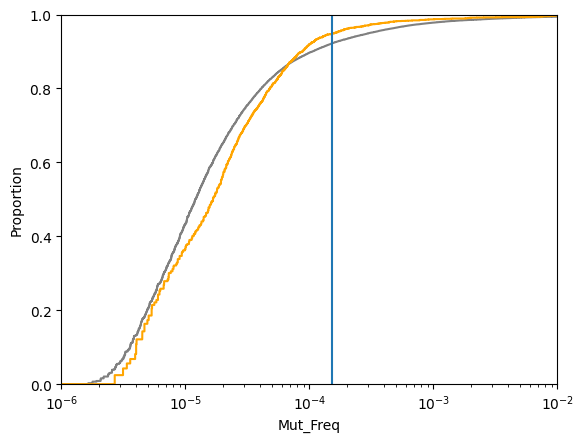

In [15]:
dis = sns.ecdfplot(x="Mut_Freq", color = 'gray', data=screen_DF2.loc[(screen_DF2['Day']=='D0') & ~(screen_DF2['Pool']=='14')])
sns.ecdfplot(x="Mut_Freq", color = 'orange', data=screen_DF2.loc[(screen_DF2['Day']=='D0') & (screen_DF2['Pool']=='14')])
dis.set_xscale('log')
plt.axvline(np.mean(background_quantiles))
dis.set(xlim=[1/1_000_000,1/100])

In [16]:
#replicate correlation
D0_muts = screen_DF2.loc[screen_DF2['Day']=='D0', ['Mismatch', 'Pool', 'Rep', 'Count', 'Mut_Freq']]
D9_muts = screen_DF2.loc[screen_DF2['Day']=='D9', ['Mismatch', 'Pool', 'Rep', 'Count', 'Mut_Freq']]
D0_D9_muts = pd.merge(D0_muts, D9_muts, on=['Pool', 'Rep', 'Mismatch'], how='outer', suffixes=('_D0', '_D9'))
D0_D9_muts = D0_D9_muts.loc[D0_D9_muts['Mut_Freq_D0']>np.mean(background_quantiles)]
D0_D9_muts = D0_D9_muts.loc[D0_D9_muts['Mut_Freq_D9']>np.mean(background_quantiles)]
D0_D9_muts['LFC'] = np.log2(D0_D9_muts['Mut_Freq_D9']/D0_D9_muts['Mut_Freq_D0'])
PV = pd.pivot_table(D0_D9_muts, values='LFC', index='Mismatch', columns='Rep')
PV[['1', '2', '3']].corr()

Rep,1,2,3
Rep,,,
1,1.000000,0.912913,0.935393
2,0.912913,1.000000,0.932917
3,0.935393,0.932917,1.000000


In [17]:
#convert mismactch strings into list of lists then mutations
mismatch_muts_ScreenDF2 = []
for mis in screen_DF2['Mismatch'].values.tolist():
    if mis == 'WT':
        mismatch_muts_ScreenDF2.append('WT')
    if mis != 'WT':
        if 'N' in mis:
            mismatch_muts_ScreenDF2.append('Wildcard')
        if 'N' not in mis:
            string_to_list = []
            mis_converted = ast.literal_eval(mis)
            for conv in mis_converted:
                string_to_list.append(ast.literal_eval(conv))
            mismatch_muts_ScreenDF2.append(string_to_list)


Mut_Effects_ScreenDF2_AA = []
Mut_Effects_ScreenDF2_Effects = []
for mismatch in mismatch_muts_ScreenDF2:
    if mismatch == 'WT':
        Mut_Effects_ScreenDF2_AA.append('WT')
        Mut_Effects_ScreenDF2_Effects.append('WT')
    if mismatch != 'WT':
        if mismatch == 'Wildcard':
            Mut_Effects_ScreenDF2_AA.append('Ambigious')
            Mut_Effects_ScreenDF2_Effects.append('Ambigious')
        if mismatch != 'Wildcard':
            mismatch_predictions = mut_to_AA_effect4(mismatch)
            Mut_Effects_ScreenDF2_AA.append(mismatch_predictions[0])
            Mut_Effects_ScreenDF2_Effects.append(mismatch_predictions[1])

In [18]:
screen_DF2['Mutation Effect'] = [str(i) for i in Mut_Effects_ScreenDF2_Effects]

In [19]:
Count_PV = pd.pivot_table(screen_DF2, values='Count', index=['Mismatch', 'Mutation Effect'], columns='Sample').reset_index()

In [20]:
Count_PV.to_csv('Veri2_Pivotable.csv')

In [22]:
#DESeq2 FC Calculations
screen_DF = pd.read_csv('Verification_Screen_Edits_Publication.csv')
sums = screen_DF[['Count', 'Sample']].groupby('Sample').sum().reset_index()
sums.columns = ['Sample', 'Sum']
screen_DF2 = pd.merge(screen_DF, sums, on='Sample')
screen_DF2['Mut_Freq'] = screen_DF2['Count']/screen_DF2['Sum']
screen_DF2[['Day', 'Pool', 'Rep']] = screen_DF2['Sample'].str.split('_', expand=True)
screen_DF2 = screen_DF2.loc[((screen_DF2['Day']=='D0') | (screen_DF2['Day']=='D9')) & (screen_DF2['Mut_Freq']>np.mean(background_quantiles))]

FC_grouped = pd.DataFrame()

for pool in range(1,15):
    group_count = screen_DF2.loc[screen_DF2['Pool']==str(pool)]
    count_PV = pd.pivot_table(group_count, values='Count', index='Mismatch', columns='Sample').dropna()
    meta = pd.DataFrame(zip(count_PV.columns, [d.split('_')[0] for d in count_PV.columns]),
                            columns=['sample', 'day']).set_index('sample')
    #Run DESeq2
    inference = DefaultInference(n_cpus=20)
    dds = DeseqDataSet(
    counts=count_PV.T,
    metadata=meta,
    design_factors="day",
    refit_cooks=True,
    n_cpus=20)
    dds.deseq2()
    Veri_Test = DeseqStats(dds, contrast=["day", "D9", "D0"])
    Veri_Test.summary()
    Veri_Test = Veri_Test.results_df
    Veri_Test['Freq'] = Veri_Test['baseMean']/Veri_Test['baseMean'].sum()
    Veri_Test['FC'] = 2**Veri_Test['log2FoldChange']
    Veri_Test['Group'] = pool
    FC_grouped = pd.concat([FC_grouped, Veri_Test[['Freq', 'FC', 'Group']].reset_index()])

Fitting size factors...
... done in 0.00 seconds.

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a s

Log2 fold change & Wald test p-value: day D9 vs D0
                                  baseMean  log2FoldChange     lfcSE  \
Mismatch                                                               
WT                            1.026495e+06        0.510451  0.410724   
["[724, 'C']", "[718, 'C']"]  3.744181e+03       -2.295493  0.596379   
["[724, 'C']"]                2.404736e+05        0.081444  0.582335   
["[726, 'G']"]                5.498155e+02        1.131859  0.748019   
["[727, 'G']"]                1.036048e+03        2.172300  0.659873   
["[730, 'G']"]                6.427410e+03        3.566891  0.958788   
["[748, 'G']", "[751, 'G']"]  4.432798e+04       -6.234284  0.411249   
["[748, 'G']"]                2.368357e+04       -4.654894  0.430928   
["[751, 'G']"]                4.086529e+03       -1.580604  0.422213   
["[777, 'G']"]                4.526764e+03        1.324684  0.598930   
["[779, 'A']"]                9.781116e+02        0.361026  0.896850   
["[802, 'C']"

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                 baseMean  log2FoldChange  \
Mismatch                                                                    
WT                                          526649.668760        0.371437   
["[724, 'C']"]                              161617.673382        0.639888   
["[725, 'A']", "[724, 'C']"]                  2040.878879        1.779030   
["[727, 'G']", "[726, 'G']"]                   470.607332        1.322419   
["[727, 'G']"]                                 379.862653        0.769550   
["[730, 'G']"]                                 940.295291        0.834375   
["[748, 'G']", "[751, 'G']"]                 58999.998100       -7.556812   
["[751, 'G']"]                                6272.955087       -3.486320   
["[777, 'G']", "[724, 'C']"]                   649.877752       -0.916724   
["[777, 'G']", "[778, 'G']", "[724, 'C']"]    1579.683401       -0.094034   
["[777, 'G']", "[778, 'G'

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
Fitting dispersions...
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip p

Log2 fold change & Wald test p-value: day D9 vs D0
                                                 baseMean  log2FoldChange  \
Mismatch                                                                    
WT                                          486238.961122       -0.145198   
["[717, 'G']"]                               12822.418986       -0.296746   
["[720, 'G']", "[717, 'G']"]                  1090.666590       -1.195487   
["[720, 'G']"]                                 814.882506        0.817432   
["[724, 'C']"]                                 869.595833        1.534114   
["[727, 'G']"]                                 225.497575        0.357870   
["[730, 'G']", "[727, 'G']"]                   239.411213        0.033856   
["[730, 'G']"]                                 681.547063       -0.134315   
["[751, 'G']"]                               40256.903479       -3.931711   
["[777, 'G']", "[778, 'G']"]                  7621.518780        0.302663   
["[777, 'G']", "[780, 'G'

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                         baseMean  \
Mismatch                                                            
WT                                                  585486.960534   
["[720, 'G']", "[870, 'G']", "[873, 'G']"]             454.801508   
["[720, 'G']"]                                       22755.877631   
["[723, 'G']", "[720, 'G']", "[717, 'G']"]            4532.442148   
["[723, 'G']", "[720, 'G']", "[726, 'G']"]             589.175936   
["[723, 'G']", "[720, 'G']", "[751, 'G']"]            1690.080377   
["[723, 'G']", "[720, 'G']", "[784, 'G']"]             872.389556   
["[723, 'G']", "[720, 'G']", "[786, 'G']", "[78...     708.831728   
["[723, 'G']", "[720, 'G']", "[838, 'G']"]            1183.523202   
["[723, 'G']", "[720, 'G']", "[870, 'G']", "[87...    2828.856151   
["[723, 'G']", "[720, 'G']", "[873, 'G']"]             649.595347   
["[723, 'G']", "[720, 'G']", "[909, 'G']"]          

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                 baseMean  log2FoldChange  \
Mismatch                                                                    
WT                                          644474.511756        0.184318   
["[720, 'G']"]                                 830.302054        1.151961   
["[723, 'G']", "[720, 'G']"]                 13399.846172        1.848311   
["[723, 'G']", "[726, 'G']"]                   777.223075        1.082030   
["[723, 'G']", "[859, 'C']"]                   546.495543        1.475431   
["[723, 'G']"]                               28519.925296        1.531956   
["[724, 'C']"]                                 801.768317        1.426606   
["[730, 'G']"]                                 899.482369        1.053143   
["[757, 'G']"]                                 490.292506        0.745337   
["[760, 'C']", "[762, 'C']"]                 52568.205914       -3.282764   
["[760, 'C']"]           

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                         baseMean  \
Mismatch                                                            
WT                                                  207775.286128   
["[720, 'G']"]                                        1076.864769   
["[723, 'G']", "[720, 'G']", "[726, 'G']"]             989.902757   
["[723, 'G']", "[720, 'G']", "[792, 'G']"]            2227.962158   
["[723, 'G']", "[720, 'G']", "[814, 'G']", "[81...     654.802018   
...                                                           ...   
["[959, 'A']"]                                        2907.246150   
["[960, 'A']", "[792, 'G']"]                          1015.451452   
["[960, 'A']"]                                        2490.485180   
["[962, 'A']", "[792, 'G']"]                           233.543215   
["[962, 'A']"]                                         592.071115   

                                                   

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                 baseMean  log2FoldChange  \
Mismatch                                                                    
WT                                          330106.756014       -0.135375   
["[723, 'G']", "[720, 'G']"]                   247.670864        1.694109   
["[723, 'G']", "[726, 'G']"]                 10466.617278        1.047079   
["[723, 'G']", "[727, 'G']", "[726, 'G']"]     644.350060        2.341493   
["[723, 'G']", "[727, 'G']"]                   371.604927        1.437766   
["[723, 'G']", "[730, 'G']", "[726, 'G']"]    2746.553774        1.365897   
["[723, 'G']", "[730, 'G']"]                 12329.806839        0.979947   
["[723, 'G']", "[826, 'C']", "[726, 'G']"]     243.490293        0.208206   
["[723, 'G']", "[826, 'C']", "[730, 'G']"]     390.423780        1.135638   
["[723, 'G']", "[826, 'C']"]                   803.577370        0.327793   
["[723, 'G']", "[936, 'G'

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                         baseMean  \
Mismatch                                                            
WT                                                  410347.319394   
["[723, 'G']", "[720, 'G']"]                          2628.420094   
["[723, 'G']", "[726, 'G']"]                         29097.803669   
["[723, 'G']", "[727, 'G']", "[726, 'G']"]           18509.678645   
["[723, 'G']", "[727, 'G']"]                          1707.664445   
["[723, 'G']", "[730, 'G']", "[726, 'G']"]            3001.965981   
["[723, 'G']", "[730, 'G']", "[727, 'G']", "[72...    2761.518084   
["[723, 'G']", "[730, 'G']"]                          1558.555905   
["[723, 'G']", "[892, 'G']", "[726, 'G']"]            1255.171808   
["[723, 'G']", "[892, 'G']", "[727, 'G']", "[72...     725.400296   
["[723, 'G']", "[892, 'G']"]                           990.339526   
["[723, 'G']", "[959, 'A']", "[726, 'G']"]          

Fitting dispersions...
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip p

Log2 fold change & Wald test p-value: day D9 vs D0
                                   baseMean  log2FoldChange     lfcSE  \
Mismatch                                                                
WT                            948355.405677        1.659044  0.069949   
["[724, 'C']"]                  2019.617927        2.058346  0.909083   
["[730, 'G']"]                   793.240067        1.313330  1.221810   
["[736, 'C']"]                121450.256867       -6.947719  0.219153   
["[763, 'G']"]                 83421.158972       -5.094984  0.191777   
["[817, 'G']"]                   909.236362        0.935616  1.129221   
["[820, 'G']", "[822, 'G']"]    1664.083433        3.160746  1.007637   
["[826, 'C']"]                301842.342789        0.013660  0.077462   
["[834, 'A']"]                  8134.884741        1.861669  1.084060   
["[936, 'G']"]                  9875.736687       -0.020895  0.365743   
["[940, 'G']", "[936, 'G']"]    4778.863814       -3.412222  0.562716   


/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                         baseMean  \
Mismatch                                                            
WT                                                  933885.851706   
["[723, 'G']", "[726, 'G']"]                          1913.580390   
["[723, 'G']", "[727, 'G']", "[726, 'G']"]            2464.304827   
["[723, 'G']", "[727, 'G']"]                          2204.465807   
["[723, 'G']", "[730, 'G']", "[726, 'G']"]             770.061341   
["[723, 'G']", "[730, 'G']", "[727, 'G']", "[72...    2051.055200   
["[723, 'G']", "[730, 'G']"]                          1920.888614   
["[723, 'G']", "[732, 'G']", "[726, 'G']", "[73...    1017.383488   
["[723, 'G']"]                                        5437.579865   
["[724, 'C']"]                                        1246.340611   
["[726, 'G']"]                                       62363.028439   
["[727, 'G']", "[726, 'G']"]                        

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                         baseMean  \
Mismatch                                                            
WT                                                  834358.419728   
["[724, 'C']"]                                        1818.617338   
["[726, 'G']"]                                        2641.906804   
["[727, 'G']", "[726, 'G']"]                          9240.304361   
["[727, 'G']"]                                       11221.250392   
["[730, 'G']", "[726, 'G']"]                         17600.366396   
["[730, 'G']", "[727, 'G']", "[726, 'G']"]           44572.037181   
["[730, 'G']", "[727, 'G']"]                         62934.150079   
["[730, 'G']", "[732, 'G']", "[727, 'G']", "[72...    2379.928105   
["[730, 'G']", "[732, 'G']", "[727, 'G']"]            3866.354354   
["[730, 'G']", "[732, 'G']"]                         15469.394623   
["[730, 'G']", "[733, 'G']"]                        

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: day D9 vs D0
                                                         baseMean  \
Mismatch                                                            
WT                                                  547445.701779   
["[724, 'C']"]                                         590.770528   
["[726, 'G']", "[730, 'G']", "[820, 'G']", "[72...    1943.492086   
["[726, 'G']"]                                        1577.654333   
["[727, 'G']", "[726, 'G']"]                           721.631109   
["[727, 'G']"]                                        3109.773017   
["[730, 'G']", "[726, 'G']"]                          7620.409379   
["[730, 'G']", "[727, 'G']", "[726, 'G']"]           10138.469870   
["[730, 'G']", "[727, 'G']"]                          8033.311694   
["[730, 'G']", "[732, 'G']", "[726, 'G']"]            1800.530998   
["[730, 'G']", "[732, 'G']", "[727, 'G']", "[72...    2443.021489   
["[730, 'G']", "[732, 'G']", "[820, 'G']", "[82...  

Fitting dispersions...
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip p

Log2 fold change & Wald test p-value: day D9 vs D0
                                                baseMean  log2FoldChange  \
Mismatch                                                                   
WT                                          1.233306e+06        0.425883   
["[730, 'G']"]                              1.273986e+03        1.744716   
["[732, 'G']", "[733, 'G']"]                4.250967e+03       -2.012510   
["[732, 'G']"]                              5.905289e+03       -2.267643   
["[733, 'G']"]                              9.210623e+02        1.117927   
["[817, 'G']"]                              3.021713e+03        2.871475   
["[820, 'G']", "[822, 'G']"]                1.790190e+04        0.138388   
["[820, 'G']", "[825, 'G']", "[822, 'G']"]  4.259399e+04       -1.338955   
["[822, 'G']"]                              7.004257e+04       -0.873272   
["[825, 'G']", "[822, 'G']"]                3.441478e+05       -3.704263   
["[825, 'G']"]                       

Fitting dispersions...
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip p

Log2 fold change & Wald test p-value: day D9 vs D0
                    baseMean  log2FoldChange     lfcSE      stat  \
Mismatch                                                           
WT              1.535164e+06       -0.915453  0.535788 -1.708611   
["[723, 'G']"]  1.030692e+04        5.375142  0.887664  6.055383   
["[724, 'C']"]  2.420844e+03        2.468355  1.161420  2.125291   
["[730, 'G']"]  1.507116e+03        1.249658  1.015160  1.230996   
["[757, 'G']"]  9.487126e+03        5.212383  1.091665  4.774710   
["[779, 'A']"]  1.453789e+03       -0.634467  1.016479 -0.624181   
["[792, 'G']"]  6.311200e+03        4.883344  1.019973  4.787718   
["[801, 'A']"]  5.233575e+02       -0.095333  0.588169 -0.162085   
["[802, 'C']"]  1.099026e+04        4.793411  1.328292  3.608702   
["[826, 'C']"]  1.302019e+04        4.615964  1.334160  3.459827   
["[834, 'A']"]  1.025598e+04       -0.968299  1.228983 -0.787886   
["[936, 'G']"]  1.036899e+04        5.161759  1.385331  3.726010 

In [23]:
#Normilization to WT
FC_WT = FC_grouped.loc[FC_grouped['Mismatch']=='WT', ['Group', 'FC']]
FC_WT.columns = ['Group', 'WT_FC']
FC_grouped = pd.merge(FC_grouped, FC_WT, on='Group')
FC_grouped['Norm_FC'] = FC_grouped['FC']/FC_grouped['WT_FC']
FC_grouped['mut_r'] = np.log(FC_grouped['Norm_FC']*np.exp(0.055*24*9))/(24*9)

In [24]:
FC_Muts = FC_grouped.loc[FC_grouped['Mismatch']!='WT']

In [25]:
#convert mismactch strings into list of lists
mismatch_muts = []
for mis in FC_Muts['Mismatch'].values.tolist():
    string_to_list = []
    mis_converted = ast.literal_eval(mis)
    for conv in mis_converted:
        string_to_list.append(ast.literal_eval(conv))
    mismatch_muts.append(string_to_list)
len(mismatch_muts)

503

In [27]:
#match sgRNA to editing window for each Group
Veri2_sgRNAs = pd.read_csv('VerificationScreen2_pools2.csv', names=['Group', 'sgName', 'Seq', 'Strand', 'Loc', 'Total'])

sgRNA_loc = []
for sgName, Seq, Strand in Veri2_sgRNAs[['sgName', 'Seq', 'Strand']].values.tolist():
    if Strand == 'pos':
        loc = abl.find(Seq[-20:].lower())
        sgRNA_loc.append([Seq, loc])
    if Strand == 'neg':
        loc = abl.find(RevComplment(Seq[-20:]).lower())        
        sgRNA_loc.append([Seq, loc])

sgRNA_loc_DF = pd.DataFrame(sgRNA_loc, columns=['Seq', 'Loc2'])

Veri2_sgRNA_DF = pd.merge(Veri2_sgRNAs[['Group', 'sgName', 'Seq', 'Strand']], sgRNA_loc_DF, on='Seq')

#for pos strand window
#abl[797+3:797+8] #4-8
#abl[797+1:797+12] #2-12

#for neg strand window
#abl[loc+12:loc+17] #4-8
#abl[loc+8:loc+19] #2-12

In [28]:
def window_4to8(mut_nuc, strand, loc2):
    if strand == 'pos':
        return(loc2 + 3 <= mut_nuc <= loc2 + 8)
    if strand == 'neg':
        return(loc2 + 12 <= mut_nuc <= loc2 + 17)
        
def window_2to12(mut_nuc, strand, loc2):
    if strand == 'pos':
        return(loc2 + 1 <= mut_nuc <= loc2 + 12)
    if strand == 'neg':
        return(loc2 + 8 <= mut_nuc <= loc2 + 19)

def window_QC(window_list):
    if (len(window_list) > 1):
        return(False)
    if 'NotABE' in window_list:
        return(False)
    if 'Out_of_Window' in window_list:
        return(False)
    if len(window_list) == 1:
        return(True)
        
def window_QC2(window_list):
    if (len(window_list) > 1) | ('NotABE' in window_list) | ('Out_of_Window' in window_list):
        return(False)
    if len(window_list) == 1:
        if 'BCR' in window_list[0]:
            return(True)

In [29]:
sgRNA_group_loc2 = Veri2_sgRNA_DF[['Group','sgName', 'Strand', 'Loc2']].values.tolist()

edit_guide_window4_8 = []
edit_guide_window4_8_QC = []

edit_guide_window2_12 = []
edit_guide_window2_12_QC = []

#match edits to window of each sgRNA
for mismatch, group in list(zip(mismatch_muts, FC_grouped['Group'].values.tolist())):
    mismatch_Nuc, details = mut_to_AA_effect4(mismatch)
    mismatch_guide_4to8 = []
    mismatch_guide_2to12 = []
    for i in range(len(mismatch)):
        if mismatch_Nuc[i] == ['a', 'G']: 
            for sgRNA_group, sgRNA_name, strand, loc2 in sgRNA_group_loc2:
                if group == sgRNA_group:
                    if window_4to8(mismatch[i][0], 'pos', loc2):
                        mismatch_guide_4to8.append(sgRNA_name)
                    if window_2to12(mismatch[i][0], 'pos', loc2):
                        mismatch_guide_2to12.append(sgRNA_name)
        if mismatch_Nuc[i] == ['t', 'C']:
            for sgRNA_group, sgRNA_name, strand, loc2 in sgRNA_group_loc2:
                if group == sgRNA_group:
                    if window_4to8(mismatch[i][0], 'neg', loc2):
                        mismatch_guide_4to8.append(sgRNA_name)
                    if window_2to12(mismatch[i][0], 'neg', loc2):
                        mismatch_guide_2to12.append(sgRNA_name)
        if mismatch_Nuc[i] != ['a', 'G']:
            if mismatch_Nuc[i] != ['t', 'C']:
                mismatch_guide_4to8.append('NotABE')
                mismatch_guide_2to12.append('NotABE')
    
    #Remove duplicate
    mismatch_guide_4to8 = list(set(mismatch_guide_4to8))
    mismatch_guide_2to12 = list(set(mismatch_guide_2to12))
    #If no guide winodw matches then edit is Out_of_Window
    if len(mismatch_guide_4to8) == 0:
        edit_guide_window4_8.append(['Out_of_Window'])
    if len(mismatch_guide_2to12) == 0:
        edit_guide_window2_12.append(['Out_of_Window'])

    #store matching results in lists
    if window_QC2(mismatch_guide_4to8) == True:
        edit_guide_window4_8.append(mismatch_guide_4to8[0])
        edit_guide_window4_8_QC.append(True)
    if window_QC2(mismatch_guide_4to8) == False:
        edit_guide_window4_8.append(mismatch_guide_4to8)
        edit_guide_window4_8_QC.append(False)
        
    if window_QC2(mismatch_guide_2to12) == True:
        edit_guide_window2_12.append(mismatch_guide_2to12[0])
        edit_guide_window2_12_QC.append(True)
    if window_QC2(mismatch_guide_2to12) == False:
        edit_guide_window2_12.append(mismatch_guide_2to12)
        edit_guide_window2_12_QC.append(False)

#unit test
len(edit_guide_window4_8) == len(mismatch_muts)

True

In [30]:
#Get DMS Growth Rates
DMS_GR = pd.read_csv('DMS_DF240603.csv')
#create dictionary of DMS calculated growth rates
DMS_GR_Dict = {}
for mut, gr in DMS_GR[['mut', 'growth_rate']].values:
    DMS_GR_Dict[mut] = gr

In [31]:
Mut_Effects = []
for mismatch in mismatch_muts:
    mismatch_predictions = mut_to_AA_effect4(mismatch)
    Mut_Effects.append(mismatch_predictions[1])


ABE_observed_mutations = []
DMS_predicted_mutations = []
Mutation_Number = []
for muts in Mut_Effects:
    temp_muts = []
    for wt_cod, mut_cod, wt_AA, pos, mut_AA in muts:
        temp_muts.append(wt_AA + str(pos) + mut_AA)
    Mutation_Number.append(len(temp_muts))   
    if len(temp_muts) == 1:
        DMS_predicted_mutations.append(DMS_GR_Dict.get(temp_muts[0], 'NotFound'))
        ABE_observed_mutations.append(temp_muts[0])
        
    if len(temp_muts) > 1:
        temp_norm_growth_rates = []
        for mut in temp_muts:
            mut_gr = DMS_GR_Dict.get(mut, 'NotFound')
            if mut_gr == 'NotFound':
                if mut[0] == mut[-1]:
                    temp_norm_growth_rates.append(0.055)
                if mut[0] != mut[-1]:
                    temp_norm_growth_rates.append('NotFound')
            if mut_gr != 'NotFound':
                temp_norm_growth_rates.append(mut_gr/0.055)
        if 'NotFound' in temp_norm_growth_rates:
            DMS_predicted_mutations.append('NotFound')
            ABE_observed_mutations.append(temp_muts)
        if 'NotFound' not in temp_norm_growth_rates:
            pred_multiAA_growth_rate = 0.055
            for norm_gr in temp_norm_growth_rates:
                pred_multiAA_growth_rate = pred_multiAA_growth_rate * norm_gr
            DMS_predicted_mutations.append(pred_multiAA_growth_rate)
            ABE_observed_mutations.append(temp_muts)

In [32]:
FC_Muts['Mut_Nuc'] = Mut_Effects
#FC_Muts['ABE_Activity'] = ABE_Activity
FC_Muts['Mut_AA'] = ABE_observed_mutations
FC_Muts['DMS_Prediction'] = DMS_predicted_mutations
FC_Muts['AA_Count'] = Mutation_Number

FC_Muts['Window4_8'] = [str(i) for i in edit_guide_window4_8]

FC_Muts['Window2_12'] = [str(i) for i in edit_guide_window2_12]


/tmp/ipykernel_459267/1049328045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FC_Muts['Mut_Nuc'] = Mut_Effects
/tmp/ipykernel_459267/1049328045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FC_Muts['Mut_AA'] = ABE_observed_mutations
/tmp/ipykernel_459267/1049328045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [34]:
sgRNA_gr = pd.read_csv('FC_group_control.csv')

In [35]:
sgRNA_gr

,Unnamed: 0,sgName,FC,Group,control_FC,Norm_FC,sgRNA_r
0,0,BCRABL_1779,0.698342,10,1.066405,0.654856,0.053040
1,1,BCRABL_1826,0.548535,10,1.066405,0.514378,0.051922
2,2,mROS26_1,0.836537,10,1.066405,0.784446,0.053876
3,3,mROS26_2,1.193275,10,1.066405,1.118969,0.055520
4,4,mROS26_3,1.100050,10,1.066405,1.031550,0.055144
...,...,...,...,...,...,...,...
136,136,mROS26_1,1.010471,9,1.272064,0.794356,0.053934
137,137,mROS26_2,1.380304,9,1.272064,1.085090,0.055378
138,138,mROS26_3,1.213300,9,1.272064,0.953804,0.054781
139,139,mROS26_4,1.322119,9,1.272064,1.039349,0.055179


In [36]:
edit_sgRNA_merged_DF = pd.merge(FC_Muts, sgRNA_gr, left_on=['Group', 'Window4_8'], right_on=['Group', 'sgName'], how='inner', suffixes=('_mut', '_sgRNA'))
edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['DMS_Prediction']=='NotFound']

,Mismatch,Freq,FC_mut,Group,WT_FC,Norm_FC_mut,mut_r,Mut_Nuc,Mut_AA,DMS_Prediction,AA_Count,Window4_8,Window2_12,Unnamed: 0,sgName,FC_sgRNA,control_FC,Norm_FC_sgRNA,sgRNA_r
45,"[""[836, 'G']""]",0.000589,1.858840,3,0.904255,2.055659,0.058336,"[[gaa, gaG, E, 281, E]]",E281E,NotFound,1,BCRABL_1833,BCRABL_1833,65,BCRABL_1833,1.235425,1.261459,0.979363,0.054903
97,"[""[938, 'C']""]",0.001134,1.128569,5,1.136279,0.993214,0.054968,"[[act, acC, T, 315, T]]",T315T,NotFound,1,BCRABL_1868,BCRABL_1868,93,BCRABL_1868,0.202017,1.053613,0.191737,0.047354


Although two ABE edits fell within the editing window, they were not identified on the DMS screen because they represent synonymous mutations. Since both exhibited wild-type (WT) like growth rates, the DMS prediction for these edits was set to a WT growth rate.

In [37]:
edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['DMS_Prediction']=='NotFound', 'DMS_Prediction'] = 0.055

In [38]:
DMS_2SD = 0.04475679365950399
edit_sgRNA_merged_DF['DMS_Dropout'] = edit_sgRNA_merged_DF['DMS_Prediction'] < DMS_2SD

In [39]:
within_4_8_window_edit_count = edit_sgRNA_merged_DF[['Group', 'Window4_8', 'Mut_AA']].groupby(['Group', 'Window4_8']).count().reset_index()
within_4_8_window_edit_count.columns = ['Group', 'Window4_8', 'Window4_8_Edit_Count']

within_2_12_window_edit_count = edit_sgRNA_merged_DF[['Group', 'Window2_12', 'Mut_AA']].groupby(['Group', 'Window2_12']).count().reset_index()
within_2_12_window_edit_count.columns = ['Group', 'Window2_12', 'Window2_12_Edit_Count']

edit_sgRNA_merged_DF = pd.merge(edit_sgRNA_merged_DF, within_4_8_window_edit_count, on=['Group', 'Window4_8'], how='left')
edit_sgRNA_merged_DF = pd.merge(edit_sgRNA_merged_DF, within_2_12_window_edit_count, on=['Group', 'Window2_12'], how='left')

In [40]:
len(edit_sgRNA_merged_DF)

187

In [41]:
#What is distribution of edits
edit_sgRNA_merged_DF['Nucleotides Edited'] = (edit_sgRNA_merged_DF['Mismatch'].apply(len)/14).astype(int)

In [42]:
edit_sums = edit_sgRNA_merged_DF[['Group', 'Window4_8', 'Freq']].groupby(['Group', 'Window4_8']).sum().reset_index()
edit_sums.columns =  ['Group', 'Window4_8', 'Window4_8_Edit_Freq_Sum']
edit_sgRNA_merged_DF =  pd.merge(edit_sgRNA_merged_DF, edit_sums, on=['Group', 'Window4_8'], how='left')

In [43]:
edit_sgRNA_merged_DF['Relative_Edit_Freq'] = edit_sgRNA_merged_DF['Freq'] / edit_sgRNA_merged_DF['Window4_8_Edit_Freq_Sum']

In [44]:
edit_sgRNA_merged_DF['Relative_Edit_Freq_bin'] = pd.cut(edit_sgRNA_merged_DF['Relative_Edit_Freq'],  bins=[0,0.05,0.1,0.2,0.4,0.6,0.8,1])

<Axes: xlabel='AA_Count', ylabel='count'>

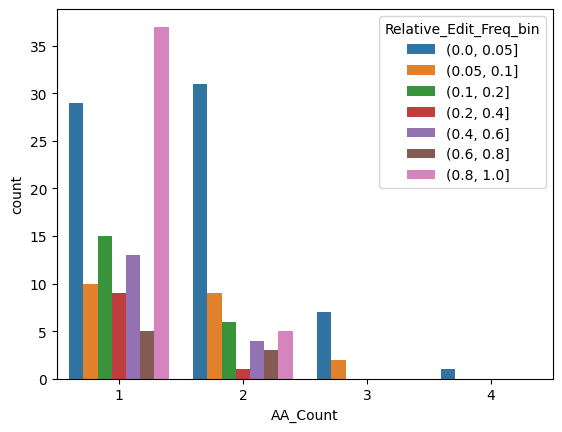

In [45]:
sns.countplot(x='AA_Count', hue='Relative_Edit_Freq_bin', data=edit_sgRNA_merged_DF)

In [46]:
sns.set_context('paper')

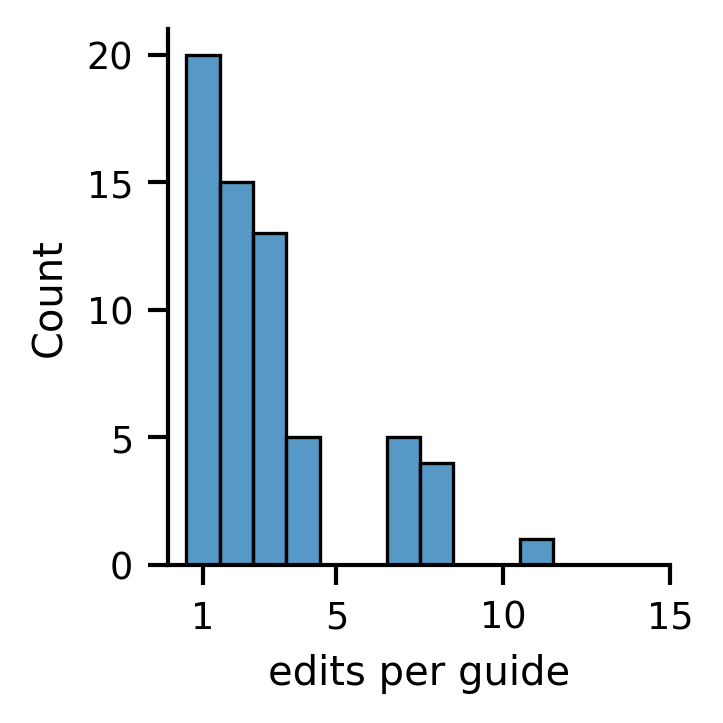

In [47]:
plt.figure(figsize=(2.5,2.5), dpi=300)
edit_dist = sns.histplot(x='Window4_8_Edit_Count',discrete=True, data=within_4_8_window_edit_count)
edit_dist.set(xlabel='edits per guide', xticks=[1,5,10,15], yticks=[0,5,10,15,20])
sns.despine()
plt.tight_layout()

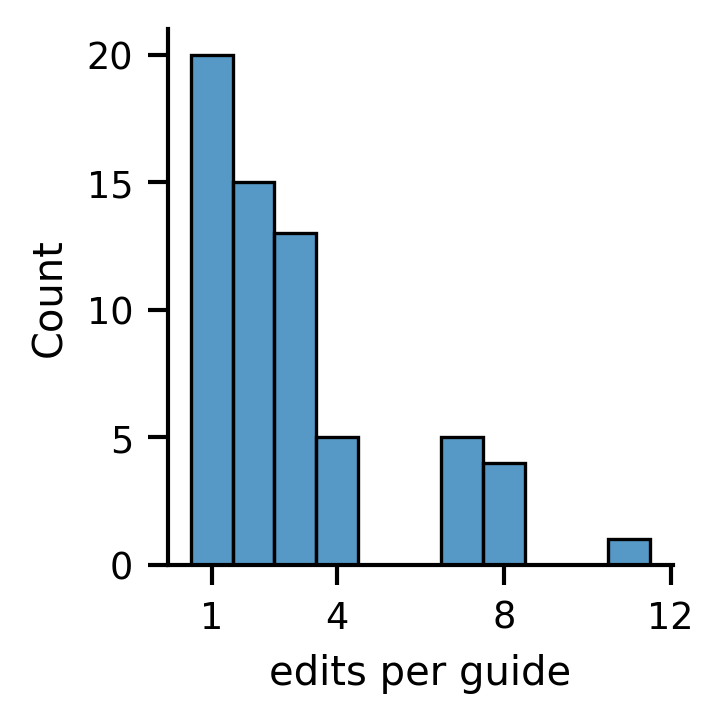

In [48]:
plt.figure(figsize=(2.5,2.5), dpi=300)
edit_dist = sns.histplot(x='Window4_8_Edit_Count',discrete=True, data=within_4_8_window_edit_count)
edit_dist.set(xlabel='edits per guide', xticks=[1,4,8,12], yticks=[0,5,10,15,20])
sns.despine()
plt.tight_layout()
edit_dist.get_figure().savefig("AA Mutated per sgRNA.pdf" , transparent=True) 

In [49]:
within_4_8_window_edit_count

,Group,Window4_8,Window4_8_Edit_Count
0,1,BCRABL_1769,2
1,1,BCRABL_1792,3
2,1,BCRABL_1803,1
3,1,BCRABL_1817,1
4,1,BCRABL_1832,2
...,...,...,...
58,10,BCRABL_1826,11
59,11,BCRABL_1780,2
60,11,BCRABL_1827,8
61,12,BCRABL_1781,3


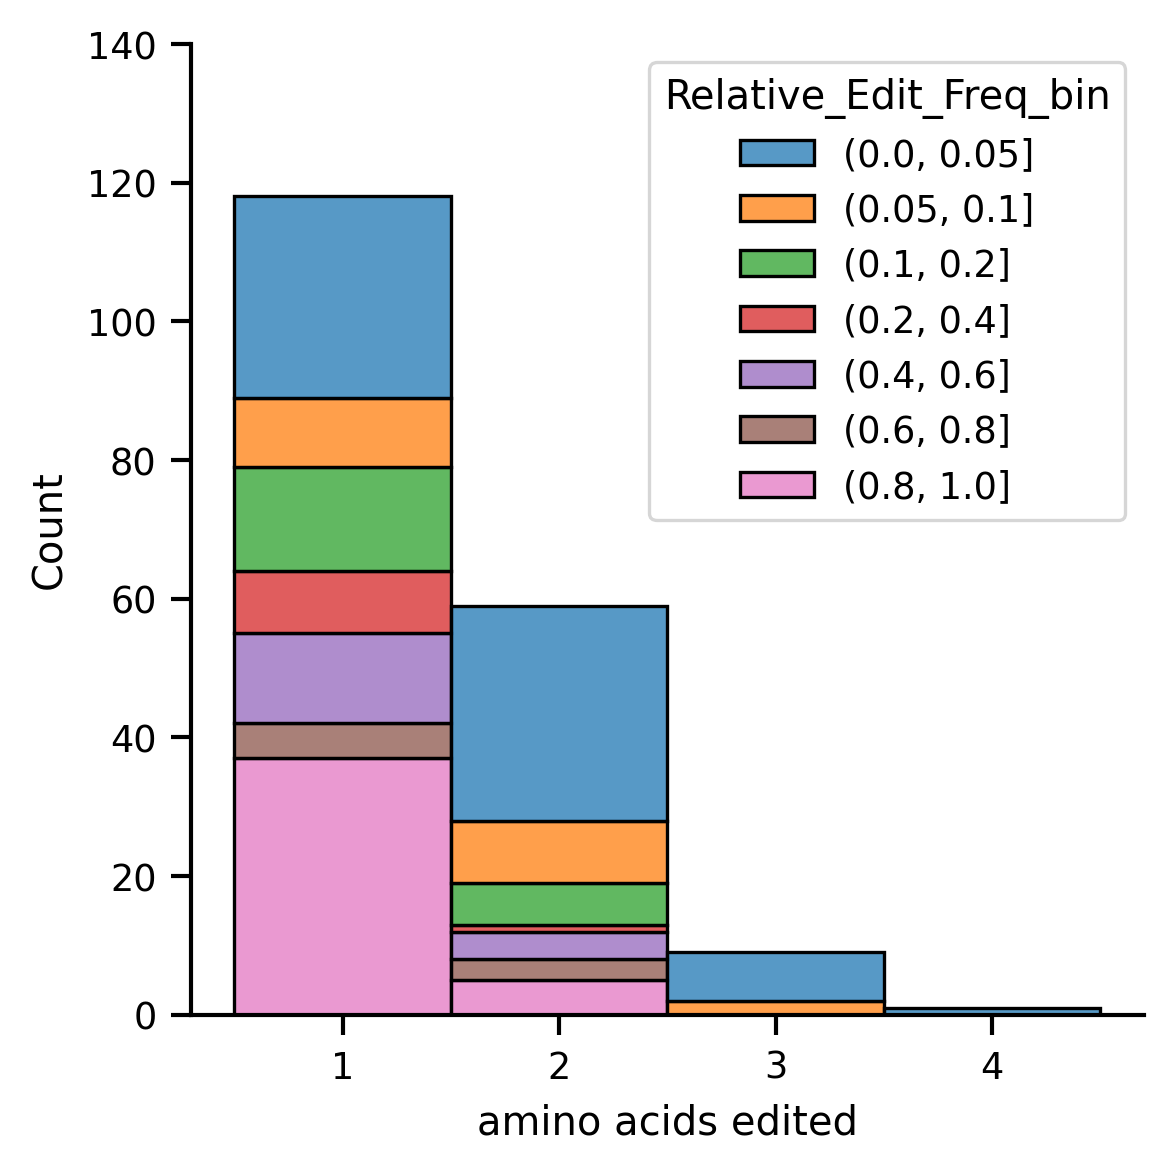

In [51]:
plt.figure(figsize=(4,4), dpi=300)
edit_dist = sns.histplot(x='AA_Count', hue='Relative_Edit_Freq_bin', multiple='stack',discrete=True, data=edit_sgRNA_merged_DF)
edit_dist.set(xticks=[1,2,3,4], xlabel='amino acids edited', ylim=[0,140])
sns.despine()
plt.tight_layout()
edit_dist.get_figure().savefig("AA Mutated per edit with relative freq.pdf" , transparent=True) 

In [52]:
edit_sgRNA_merged_DF['Window4_8'].drop_duplicates()

0      BCRABL_1769
2      BCRABL_1792
5      BCRABL_1803
6      BCRABL_1817
7      BCRABL_1832
          ...     
156    BCRABL_1826
167    BCRABL_1780
169    BCRABL_1827
177    BCRABL_1781
180    BCRABL_1828
Name: Window4_8, Length: 63, dtype: object

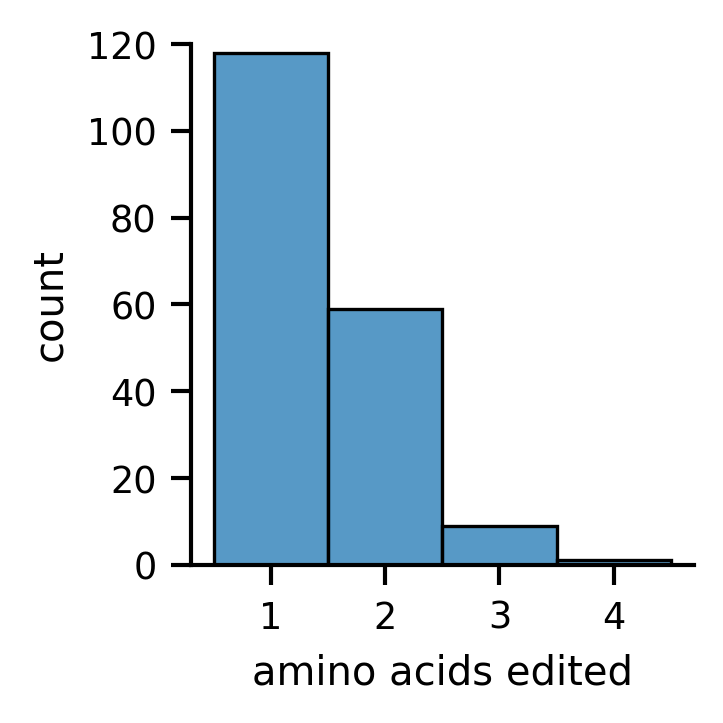

In [54]:
plt.figure(figsize=(2.5,2.5), dpi=300)
edit_dist = sns.histplot(x='AA_Count',discrete=True, data=edit_sgRNA_merged_DF)
edit_dist.set(xticks=[1,2,3,4], xlabel='amino acids edited', ylabel='count', ylim=[0,120])
sns.despine()
plt.tight_layout()
edit_dist.get_figure().savefig("AA Mutated per edit.pdf" , transparent=True) 

In [55]:
edit_sgRNA_merged_DF[['sgRNA_r', 'mut_r']].corr()

,sgRNA_r,mut_r
sgRNA_r,1.000000,0.677384
mut_r,0.677384,1.000000


In [56]:
edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['AA_Count']==1, ['sgRNA_r', 'mut_r']].corr()

,sgRNA_r,mut_r
sgRNA_r,1.000000,0.703434
mut_r,0.703434,1.000000


In [57]:
edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['Window4_8_Edit_Count']==1, ['sgRNA_r', 'mut_r']].corr()

,sgRNA_r,mut_r
sgRNA_r,1.000000,0.940795
mut_r,0.940795,1.000000


In [239]:
edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['Window2_12_Edit_Count']==1, ['sgRNA_r', 'mut_r']].corr()

,sgRNA_r,mut_r
sgRNA_r,1.000000,0.946199
mut_r,0.946199,1.000000


In [58]:
pearsonr(edit_sgRNA_merged_DF['sgRNA_r'], edit_sgRNA_merged_DF['mut_r'])

PearsonRResult(statistic=0.6773836426505804, pvalue=1.8459621464411892e-26)

In [59]:
# Note the difference in argument order
Y = edit_sgRNA_merged_DF['sgRNA_r']
X = edit_sgRNA_merged_DF['mut_r']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(edit_sgRNA_merged_DF['sgRNA_r'], edit_sgRNA_merged_DF['mut_r']*results.params[1] + results.params[0])

0.0021333040954338296

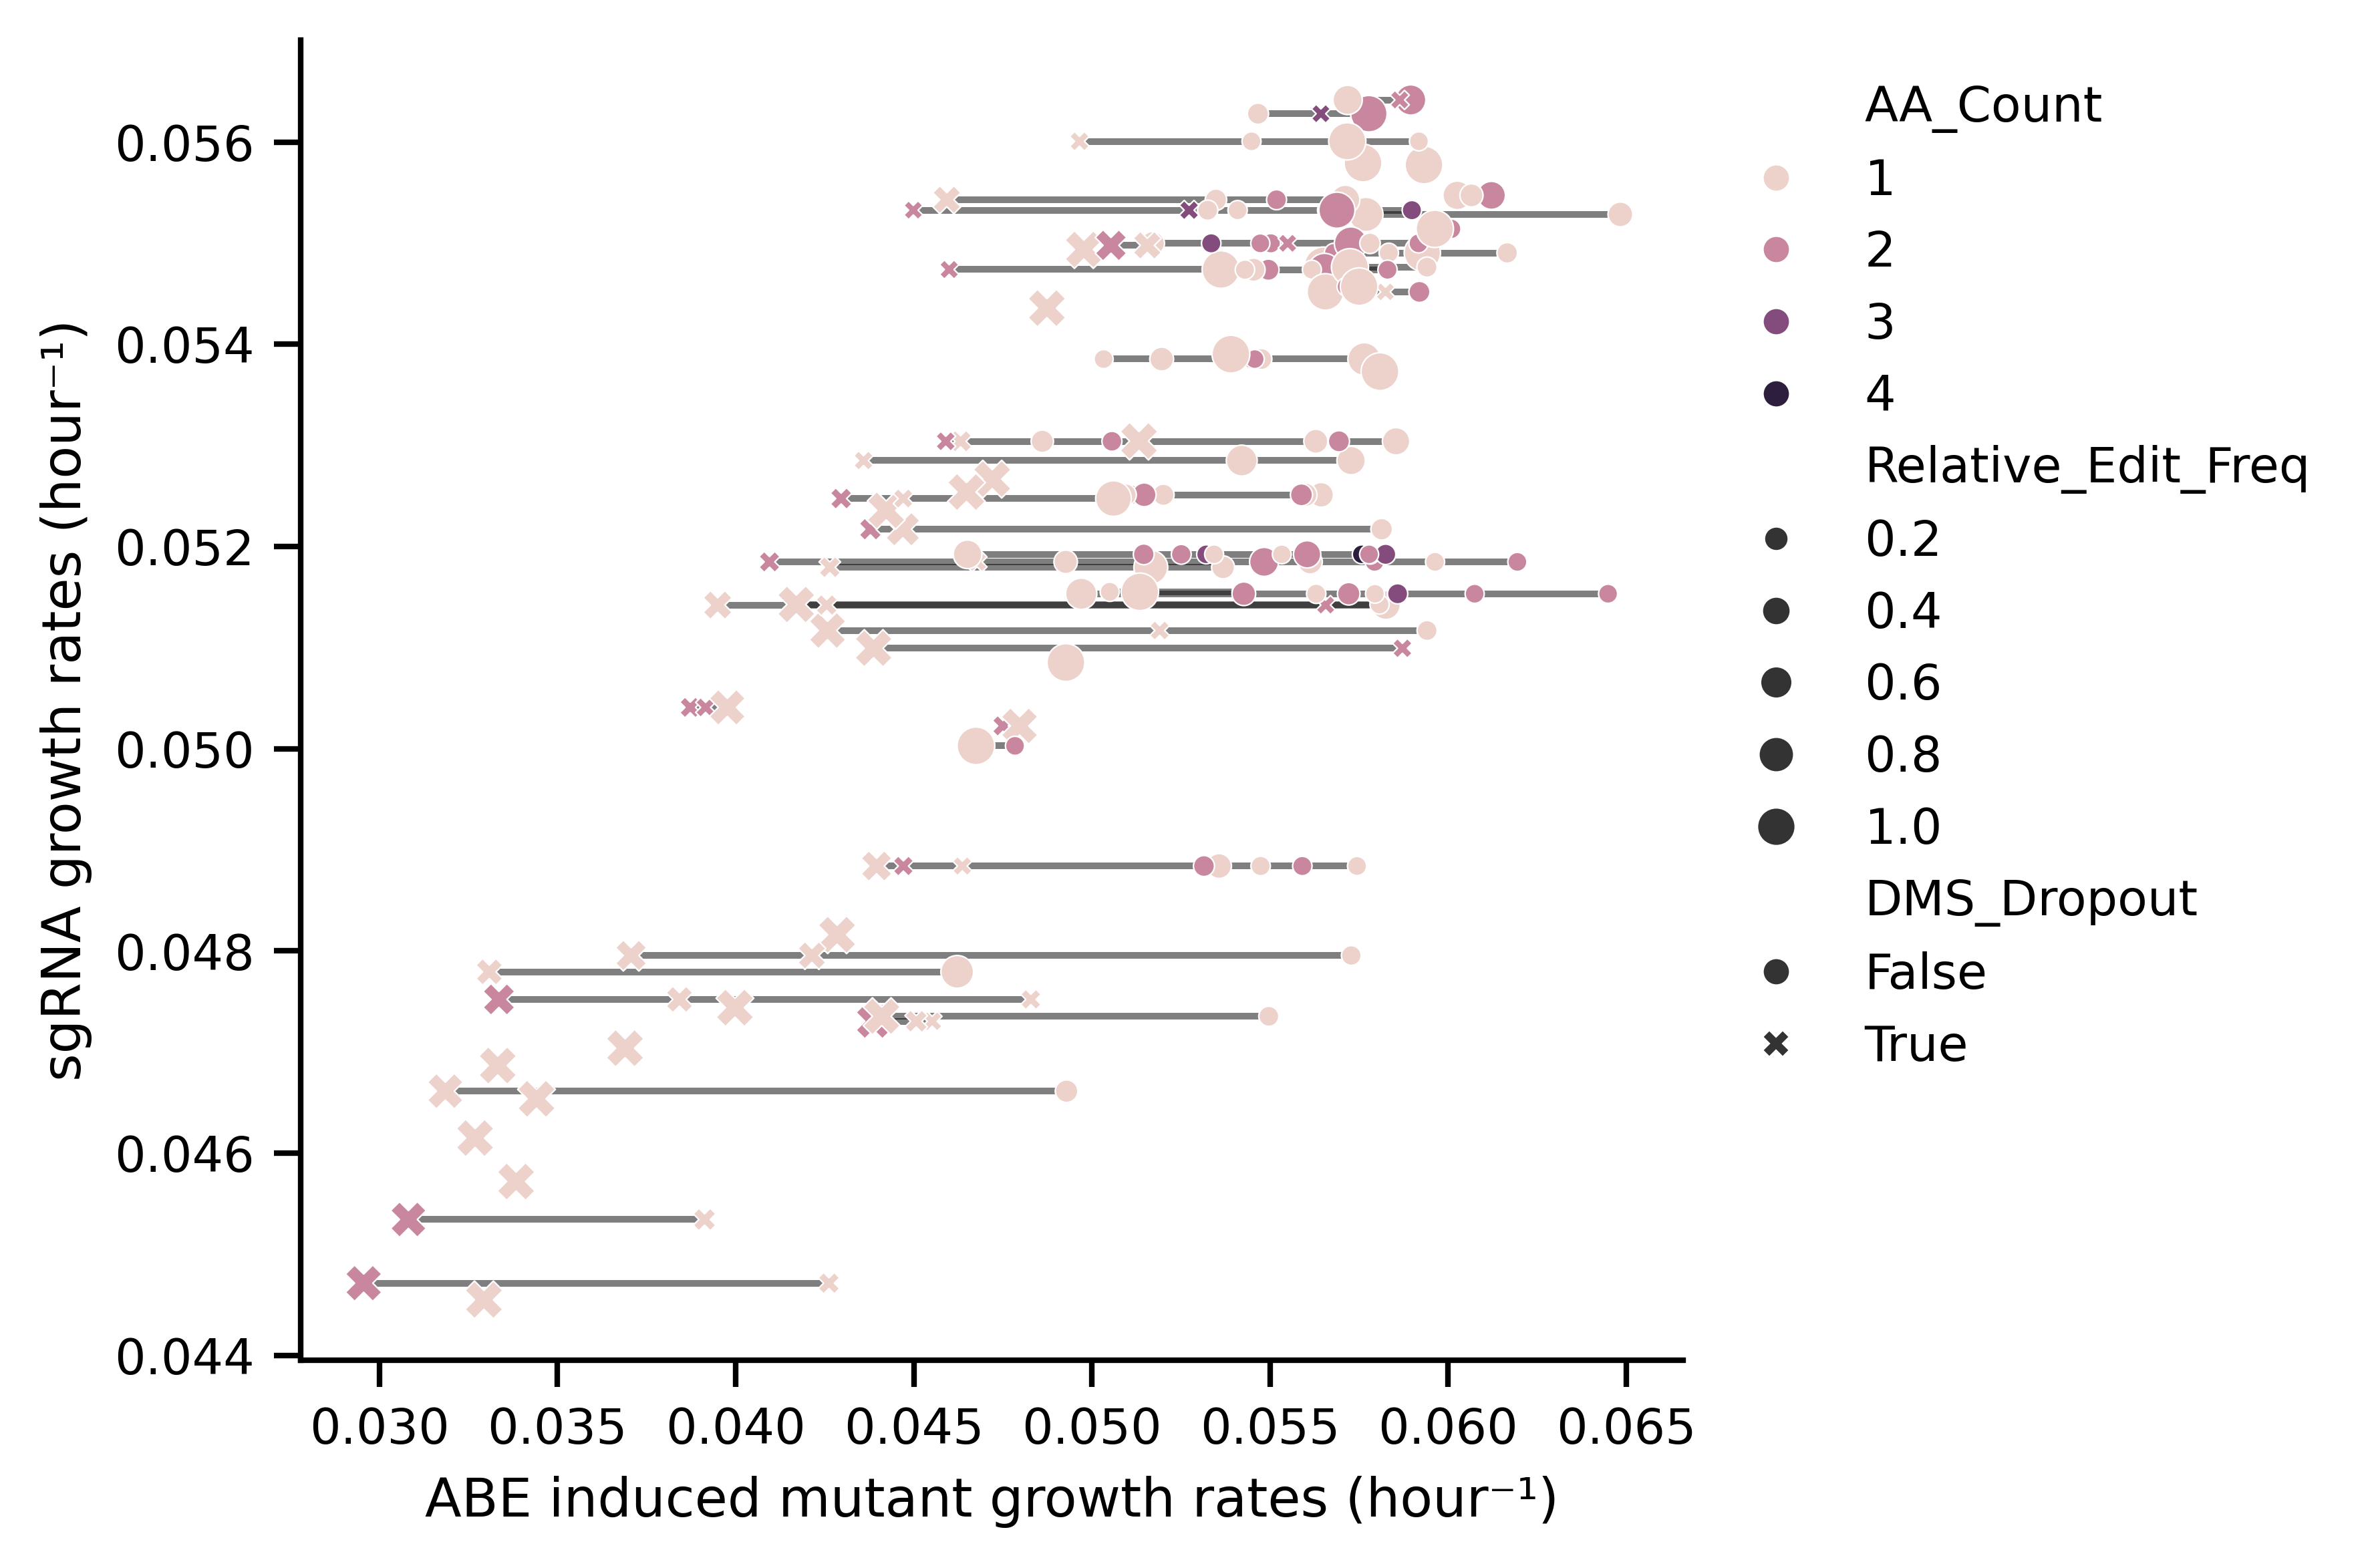

In [60]:
#lined sgRNA connection
edit_sgRNA_merged_DF['Window4_8'] = edit_sgRNA_merged_DF['Window4_8'].astype('str')
sg_min = edit_sgRNA_merged_DF[['Group', 'Window4_8', 'sgRNA_r', 'mut_r']].groupby(['Group', 'Window4_8', 'sgRNA_r']).min().reset_index()
sg_min.columns = ['Group', 'Window4_8', 'sgRNA_r', 'mut_r_min']
sg_max= edit_sgRNA_merged_DF[['Group', 'Window4_8', 'mut_r']].groupby(['Group', 'Window4_8']).max().reset_index()
sg_max.columns = ['Group', 'Window4_8', 'mut_r_max']

sg_min_max = pd.merge(sg_min, sg_max, on=['Group', 'Window4_8'])

plt.figure(figsize=(6,4), dpi=600)
Veri_sgRNA = sns.scatterplot(x='mut_r', y='sgRNA_r', hue='AA_Count', size='Relative_Edit_Freq', style='DMS_Dropout',  data=edit_sgRNA_merged_DF)
Veri_sgRNA.set(xlabel='ABE induced mutant growth rates (hour⁻¹)', ylabel='sgRNA growth rates (hour⁻¹)')
plt.hlines(sg_min_max['sgRNA_r'], sg_min_max['mut_r_min'], sg_min_max['mut_r_max'], alpha=0.5, color='black', zorder=0)
sns.move_legend(Veri_sgRNA, "upper left", frameon=False,bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
Veri_sgRNA.get_figure().savefig("Veri2 All Edits v sgRNA.pdf" , transparent=True) 

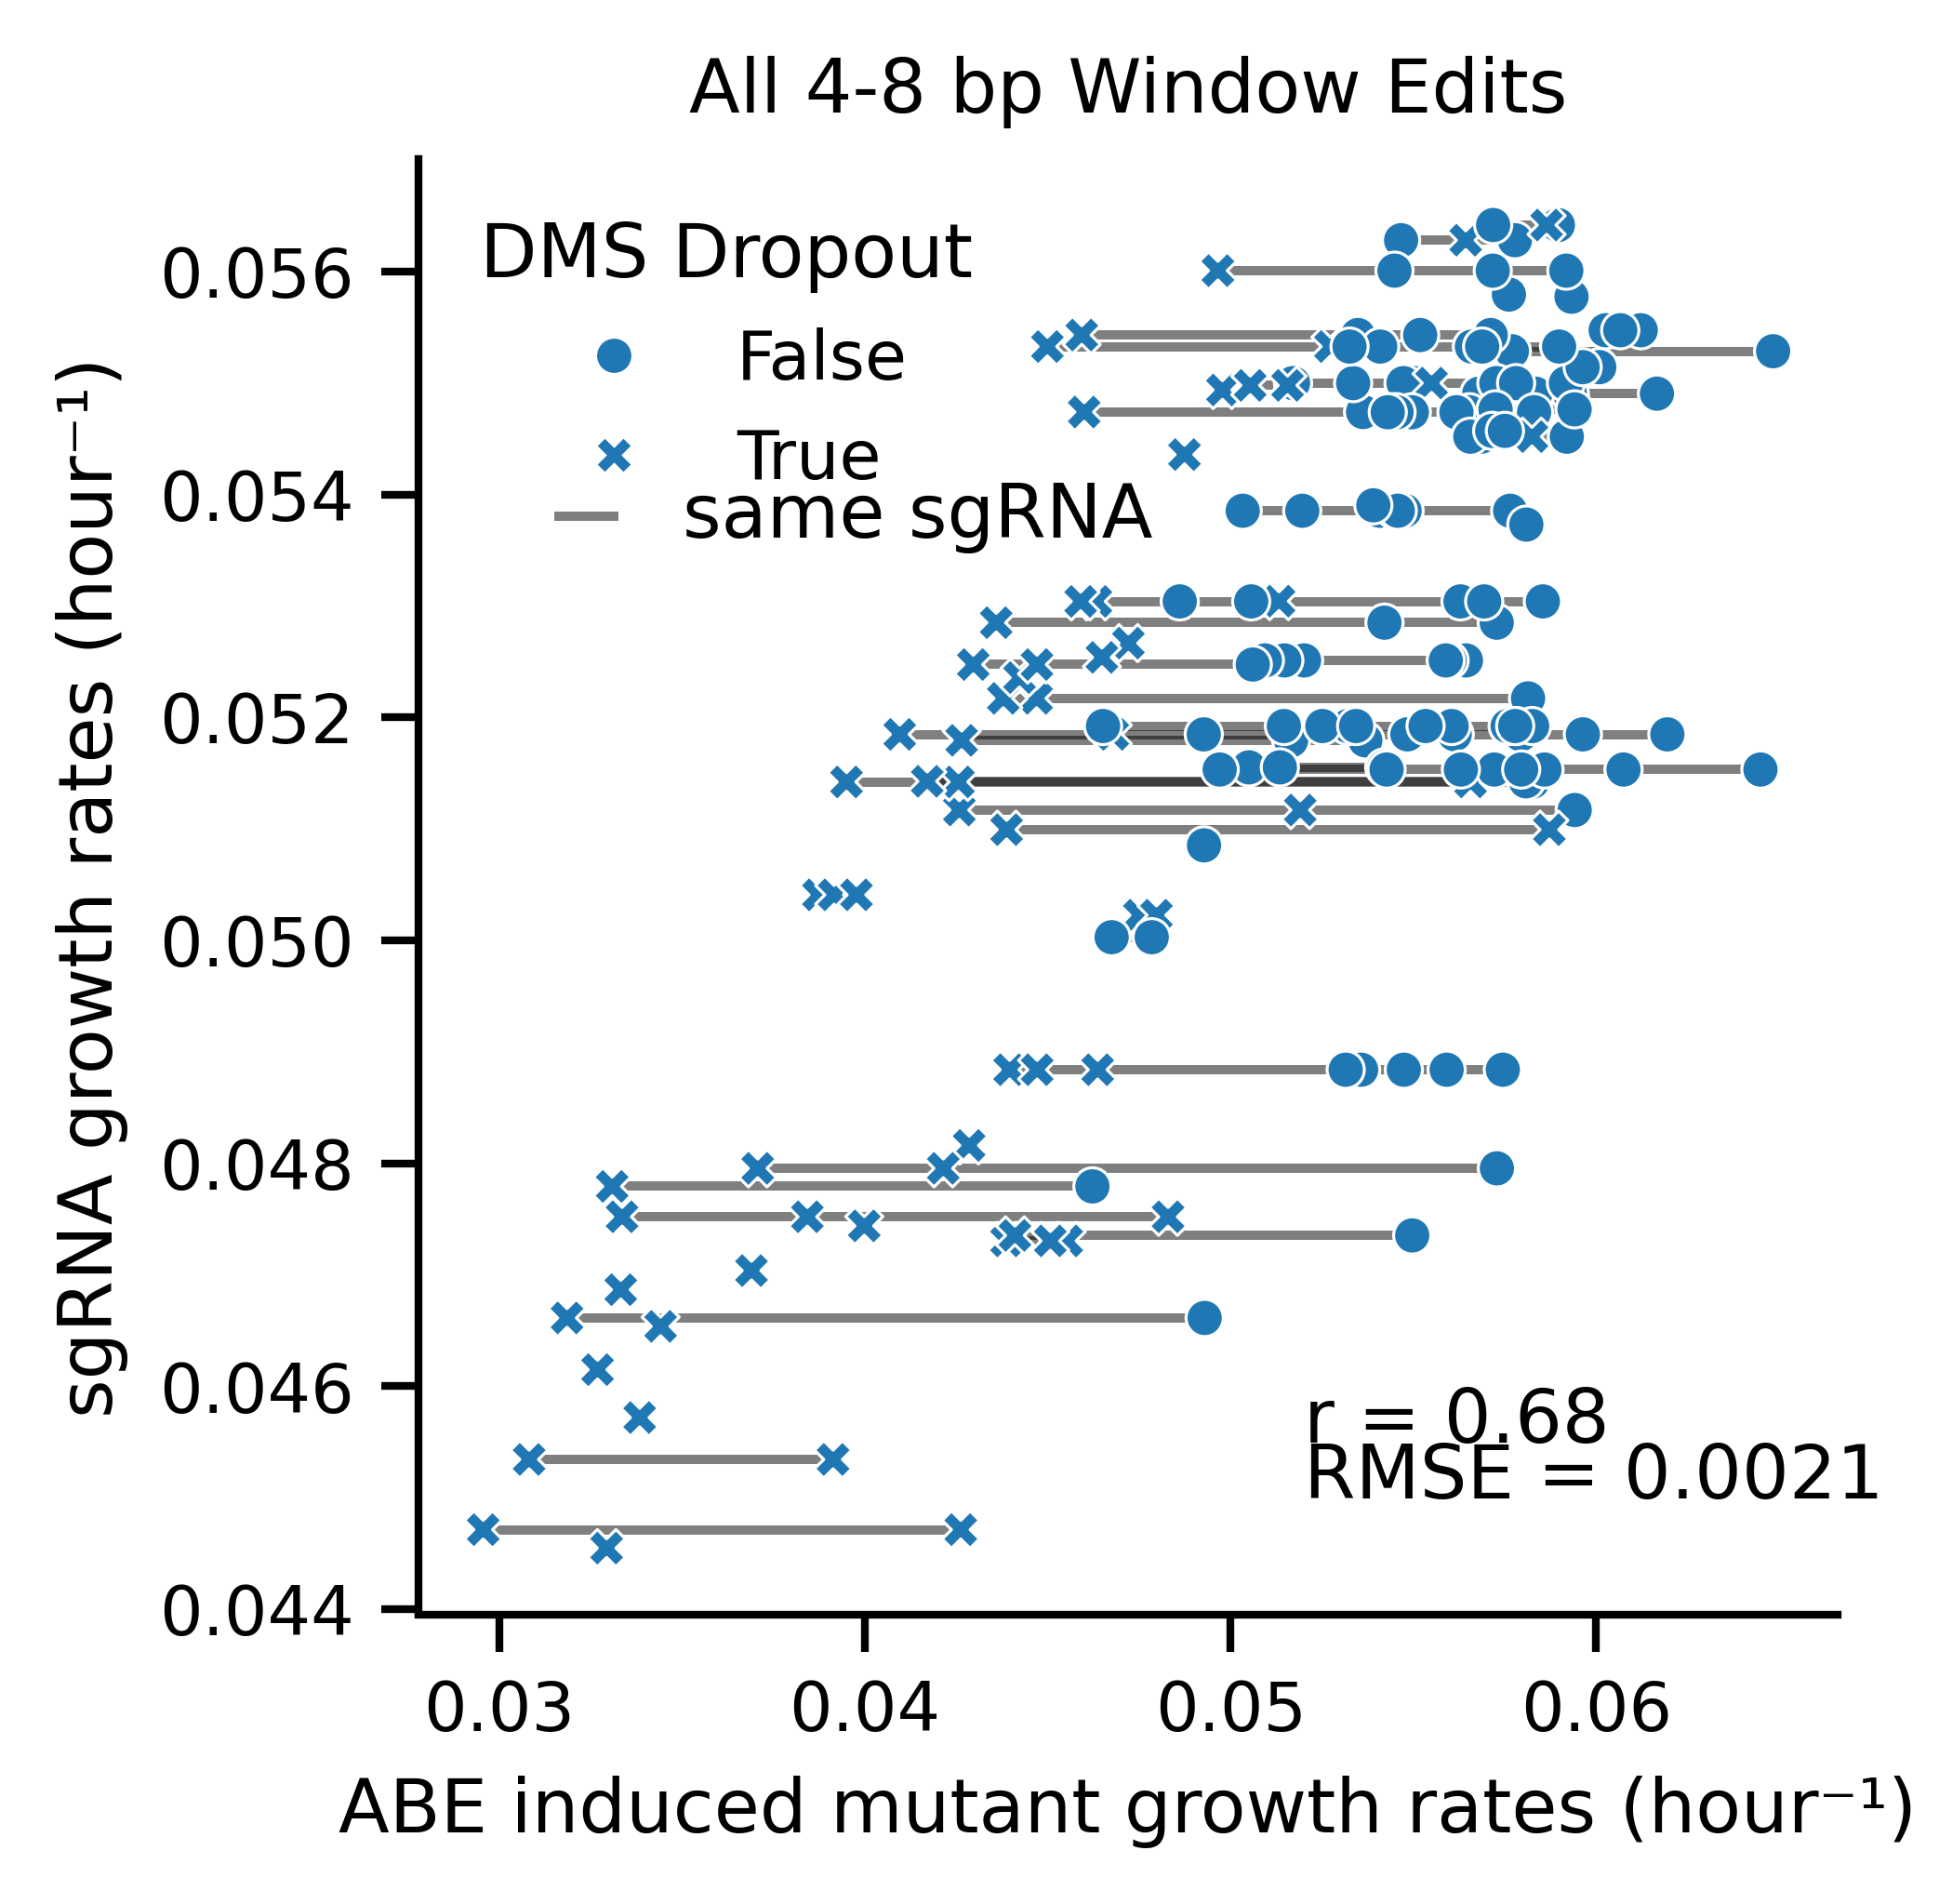

In [61]:
#lined sgRNA connection
edit_sgRNA_merged_DF['Window4_8'] = edit_sgRNA_merged_DF['Window4_8'].astype('str')
sg_min = edit_sgRNA_merged_DF[['Group', 'Window4_8', 'sgRNA_r', 'mut_r']].groupby(['Group', 'Window4_8', 'sgRNA_r']).min().reset_index()
sg_min.columns = ['Group', 'Window4_8', 'sgRNA_r', 'mut_r_min']
sg_max= edit_sgRNA_merged_DF[['Group', 'Window4_8', 'mut_r']].groupby(['Group', 'Window4_8']).max().reset_index()
sg_max.columns = ['Group', 'Window4_8', 'mut_r_max']

sg_min_max = pd.merge(sg_min, sg_max, on=['Group', 'Window4_8'])

plt.figure(figsize=(3.5,3.5), dpi=600)
Veri_sgRNA = sns.scatterplot(x='mut_r', y='sgRNA_r', style='DMS_Dropout',  data=edit_sgRNA_merged_DF)
Veri_sgRNA.set(xlabel='ABE induced mutant growth rates (hour⁻¹)', ylabel='sgRNA growth rates (hour⁻¹)', title='All 4-8 bp Window Edits')
plt.hlines(sg_min_max['sgRNA_r'], sg_min_max['mut_r_min'], sg_min_max['mut_r_max'], alpha=0.5, color='black', zorder=0)
Veri_sgRNA.text(0.035, 0.0538, 'same sgRNA', horizontalalignment='left', va='center')
plt.hlines(0.0538, 0.0315, 0.03325, alpha=0.5, color='black', zorder=0)
Veri_sgRNA.text(0.052, 0.0455, 'r = 0.68', horizontalalignment='left')
Veri_sgRNA.text(0.052, 0.045, 'RMSE = 0.0021', horizontalalignment='left')
Veri_sgRNA.legend(frameon=False, title='DMS Dropout')
#sns.move_legend(Veri_sgRNA, "upper left",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
Veri_sgRNA.get_figure().savefig("Veri2 All Edits v sgRNA2.pdf" , transparent=True) 

In [62]:
major_edit = edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['Relative_Edit_Freq']>0.5]

#lined sgRNA connection
major_edit['Window4_8'] = major_edit['Window4_8'].astype('str')
sg_min = major_edit[['Group', 'Window4_8', 'sgRNA_r', 'mut_r']].groupby(['Group', 'Window4_8', 'sgRNA_r']).min().reset_index()
sg_min.columns = ['Group', 'Window4_8', 'sgRNA_r', 'mut_r_min']
sg_max= major_edit[['Group', 'Window4_8', 'mut_r']].groupby(['Group', 'Window4_8']).max().reset_index()
sg_max.columns = ['Group', 'Window4_8', 'mut_r_max']
sg_min_max = pd.merge(sg_min, sg_max, on=['Group', 'Window4_8'])

pearsonr(major_edit['sgRNA_r'], major_edit['mut_r'])

/tmp/ipykernel_459267/2215552349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_edit['Window4_8'] = major_edit['Window4_8'].astype('str')


PearsonRResult(statistic=0.9253464837172215, pvalue=2.0904180973616142e-24)

In [63]:
major_edit_single_AA = major_edit.loc[major_edit['AA_Count']==1]
pearsonr(major_edit_single_AA['sgRNA_r'], major_edit_single_AA['mut_r'])

PearsonRResult(statistic=0.9109784016437037, pvalue=1.5590091168366577e-18)

In [246]:
# Note the difference in argument order
Y = major_edit['sgRNA_r']
X = major_edit['mut_r']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(major_edit['sgRNA_r'], major_edit['mut_r']*results.params[1] + results.params[0])

0.0013305159135588935

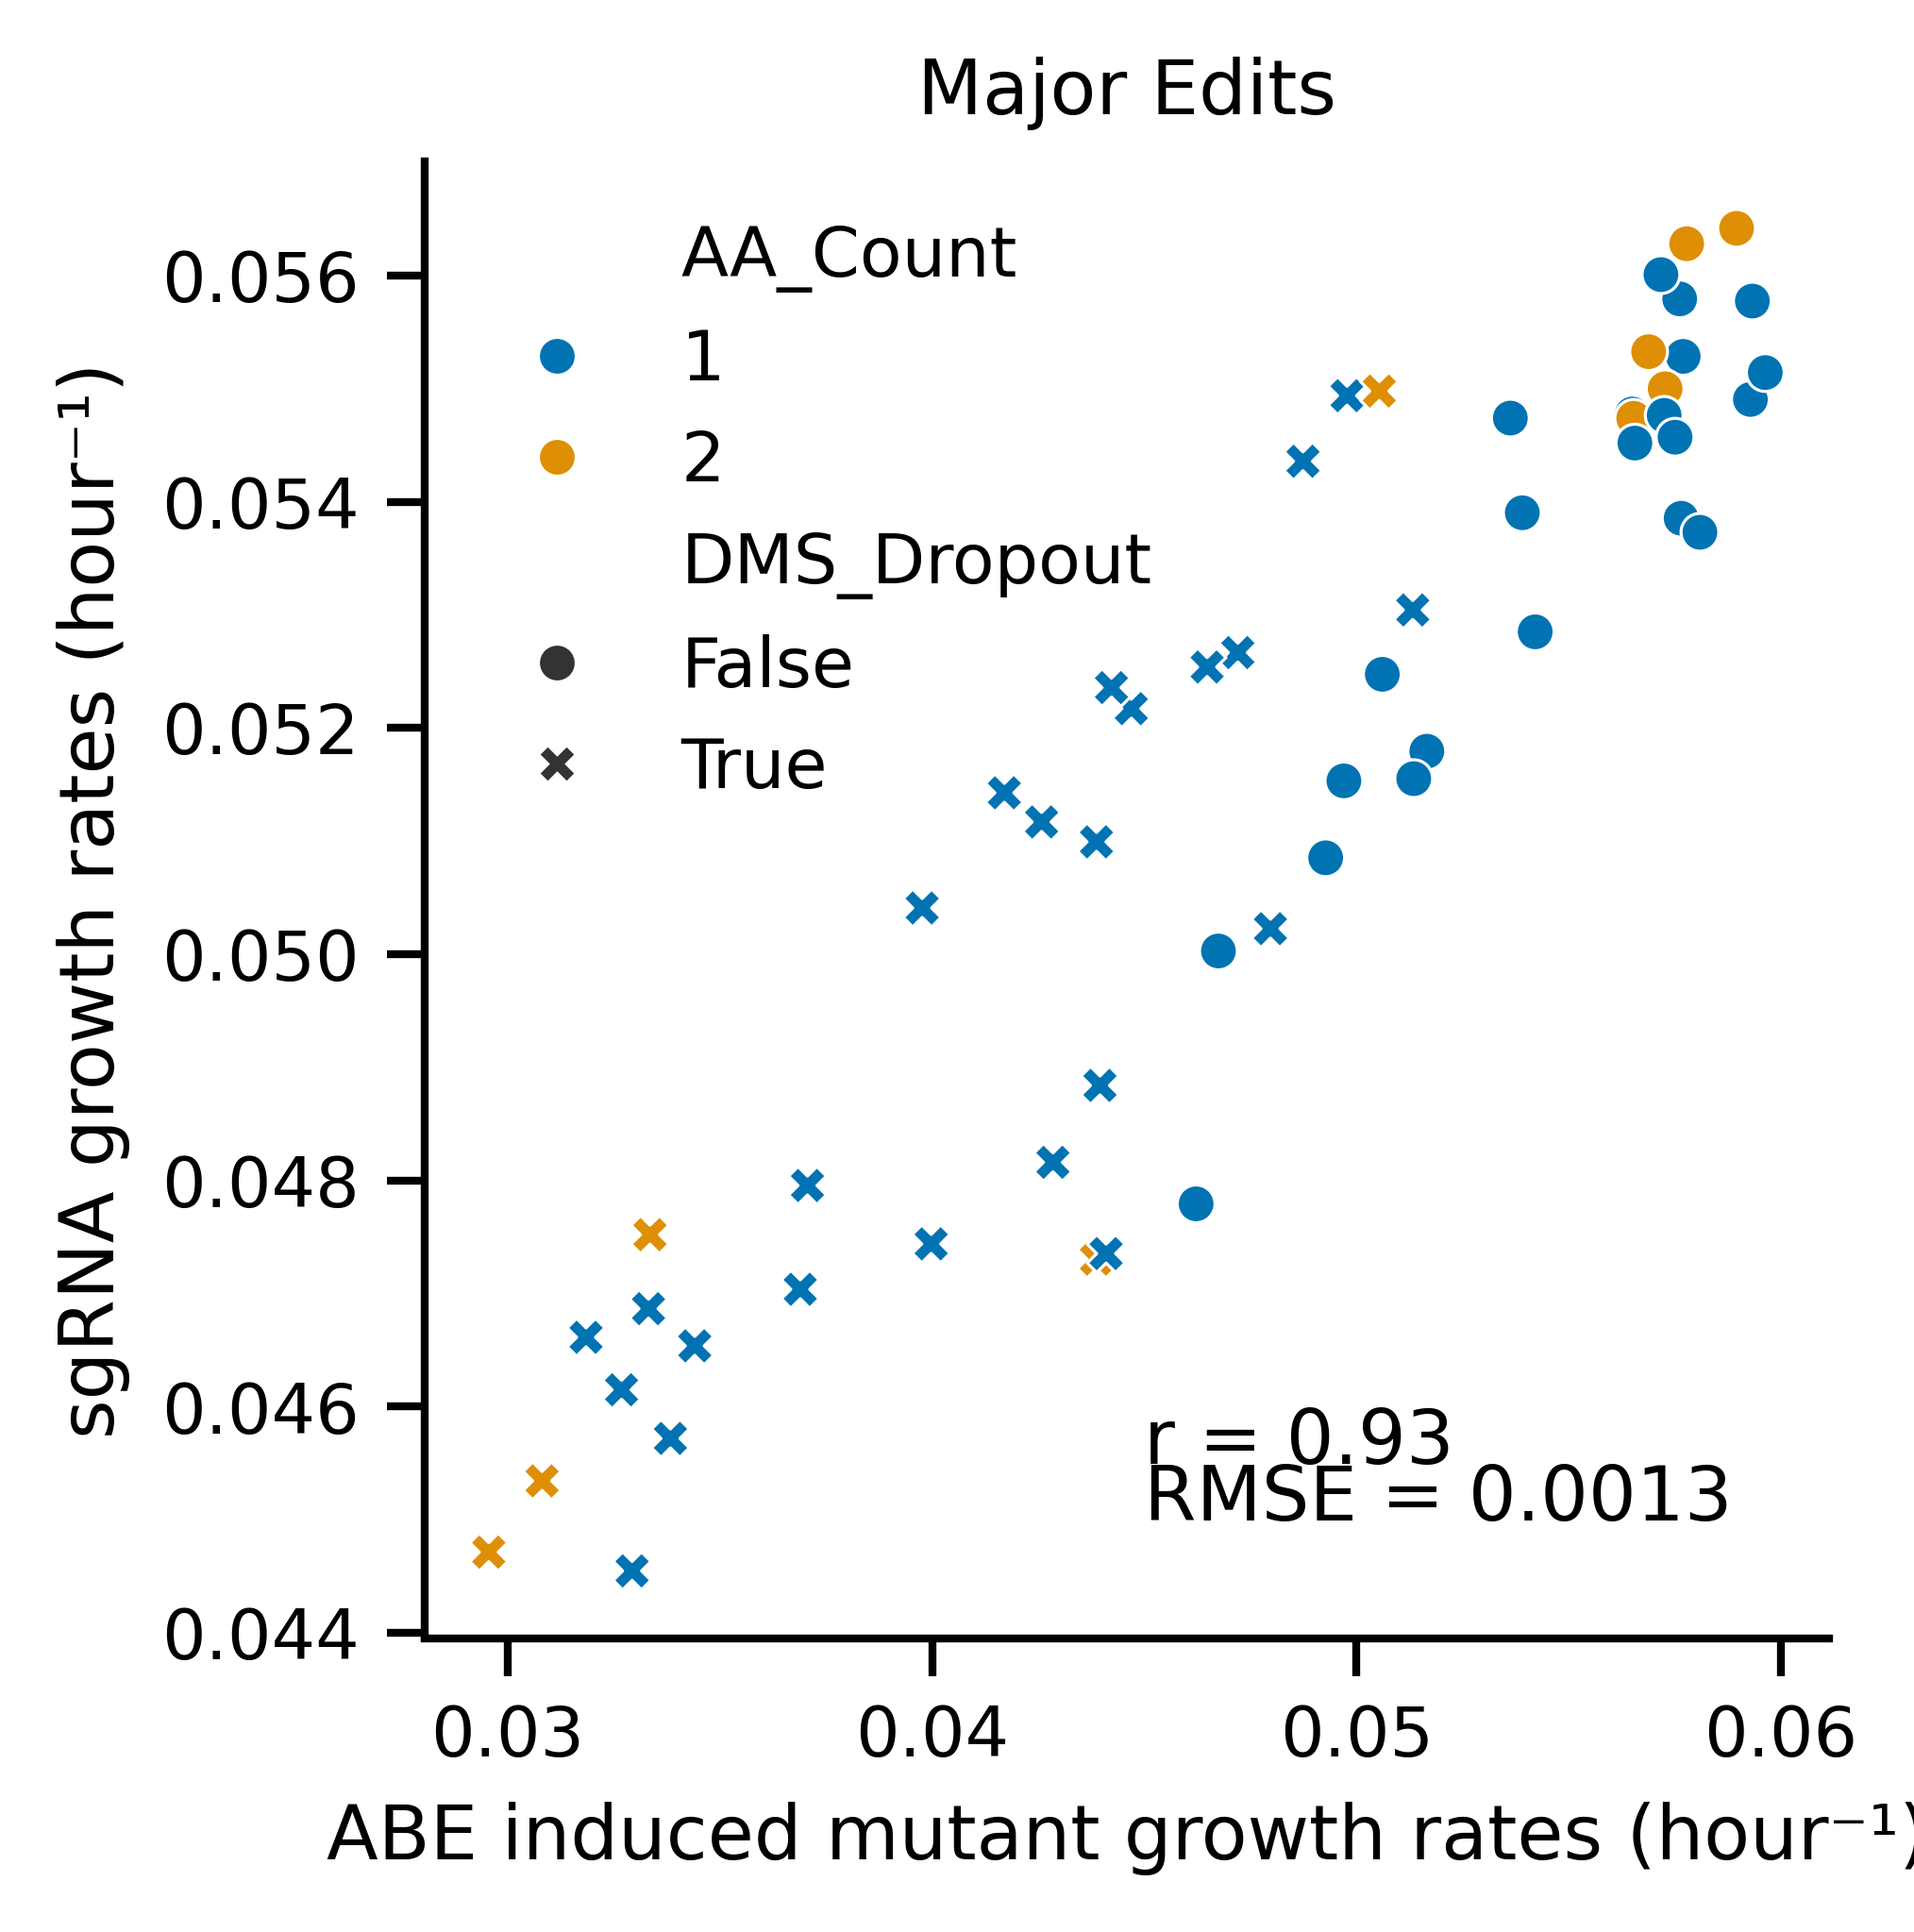

In [247]:
plt.figure(figsize=(3.5,3.5), dpi=600)
Veri_sgRNA = sns.scatterplot(x='mut_r', y='sgRNA_r', hue='AA_Count', style='DMS_Dropout',  data=major_edit, palette='colorblind')
Veri_sgRNA.set(xlabel='ABE induced mutant growth rates (hour⁻¹)', ylabel='sgRNA growth rates (hour⁻¹)', title='Major Edits')
Veri_sgRNA.text(0.045, 0.0455, 'r = 0.93', horizontalalignment='left')
Veri_sgRNA.text(0.045, 0.045, 'RMSE = 0.0013', horizontalalignment='left')
Veri_sgRNA.legend(frameon=False)
#sns.move_legend(Veri_sgRNA, "upper left",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
Veri_sgRNA.get_figure().savefig("Veri2 Major Edits v sgRNA.pdf" , transparent=True) 

In [248]:
major_edit[['sgRNA_r', 'mut_r']].corr()

,sgRNA_r,mut_r
sgRNA_r,1.000000,0.925346
mut_r,0.925346,1.000000


In [66]:
## Weighted Edit Model
#Extract Day 0 sgRNA Freq
Veri2_sgRNA_Freq = pd.read_csv('Veri2_sgRNA_Screen.csv')
Veri2_sgRNA_Freq = Veri2_sgRNA_Freq.drop('Unnamed: 0', axis=1)
Veri2_sgRNA_Freq = Veri2_sgRNA_Freq.set_index('sgName')
Norm = Veri2_sgRNA_Freq.div(Veri2_sgRNA_Freq.sum(0))
Norm_melt = Norm.reset_index().melt(id_vars=['sgName'])
Norm_melt.columns = ['sgName', 'Sample', 'sgRNA_Freq']
Norm_melt[['Veri', 'Day', 'Group', 'Rep']] = Norm_melt['Sample'].str.split('_', expand=True)
Norm_melt_D0 = Norm_melt.loc[Norm_melt['Day']=='D0']
Norm_melt_D0_mean = Norm_melt_D0[['sgName', 'Group', 'sgRNA_Freq']].groupby(['Group', 'sgName']).mean().reset_index()
Norm_melt_D0_mean.columns = ['Group', 'sgName', 'sgRNA_Freq_D0']
Norm_melt_D0_mean['Group'] = Norm_melt_D0_mean['Group'].astype('int64')

Weighted_DF = pd.merge(edit_sgRNA_merged_DF, Norm_melt_D0_mean, on = ['Group', 'sgName'], how='left')
Weighted_DF['Rel_Edit_sgRNA_Freq_Diff'] = (Weighted_DF['sgRNA_Freq_D0'] - Weighted_DF['Window4_8_Edit_Freq_Sum'])/Weighted_DF['sgRNA_Freq_D0']
Weighted_DF['Rel_WT_Freq'] = (Weighted_DF['sgRNA_Freq_D0'] - Weighted_DF['Window4_8_Edit_Freq_Sum'])/Weighted_DF['sgRNA_Freq_D0']
Weighted_DF['Rel_Edit_r'] = (Weighted_DF['Freq']/ Weighted_DF['sgRNA_Freq_D0']) * Weighted_DF['mut_r']


#edi_pred_sgRNA_r  = edit_sgRNA_merged_DF[['Group', 'sgName', 'Rel_Edit_r']].groupby(['Group', 'sgName']).sum().reset_index()
#edi_pred_sgRNA_r = pd.merge(edi_pred_sgRNA_r, edit_sgRNA_merged_DF[['Group', 'sgName', 'sgRNA_r']].drop_duplicates(), on=['Group', 'sgName'])

In [67]:
edit_sgRNA_merged_DF[['Group', 'sgName', 'Mismatch']].groupby(['Group', 'sgName']).count().reset_index()

,Group,sgName,Mismatch
0,1,BCRABL_1769,2
1,1,BCRABL_1792,3
2,1,BCRABL_1803,1
3,1,BCRABL_1817,1
4,1,BCRABL_1832,2
...,...,...,...
58,10,BCRABL_1826,11
59,11,BCRABL_1780,2
60,11,BCRABL_1827,8
61,12,BCRABL_1781,3


In [68]:
Weighted_DF2 = pd.merge(Weighted_DF[['Group', 'sgName', 'sgRNA_r','Rel_WT_Freq']].drop_duplicates(), Weighted_DF[['Group', 'sgName', 'Rel_Edit_r']].groupby(['Group', 'sgName']).sum().reset_index(), on=['Group', 'sgName'])
Weighted_DF2['Pred_sgRNA_r'] = Weighted_DF2['Rel_WT_Freq']*0.055 + Weighted_DF2['Rel_Edit_r']
Weighted_DF2 = pd.merge(Weighted_DF2, edit_sgRNA_merged_DF[['Group', 'sgName', 'Mismatch']].groupby(['Group', 'sgName']).count().reset_index(), on=['Group', 'sgName'])

In [69]:
Weighted_DF2['Pred_sgRNA_r'] = Weighted_DF2['Rel_WT_Freq']*0.055 + Weighted_DF2['Rel_Edit_r'] 

In [70]:
# Note the difference in argument order
Y = Weighted_DF2['sgRNA_r']
X = Weighted_DF2['Pred_sgRNA_r']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(Weighted_DF2['sgRNA_r'], Weighted_DF2['Pred_sgRNA_r']*results.params[1] + results.params[0])

0.0012230970624482538

In [71]:
pearsonr(Weighted_DF2['sgRNA_r'], Weighted_DF2['Pred_sgRNA_r'])

PearsonRResult(statistic=0.9325238469940103, pvalue=1.129016792327402e-28)

In [72]:
0.9325238469940103*0.9325238469940103

0.8696007252125082

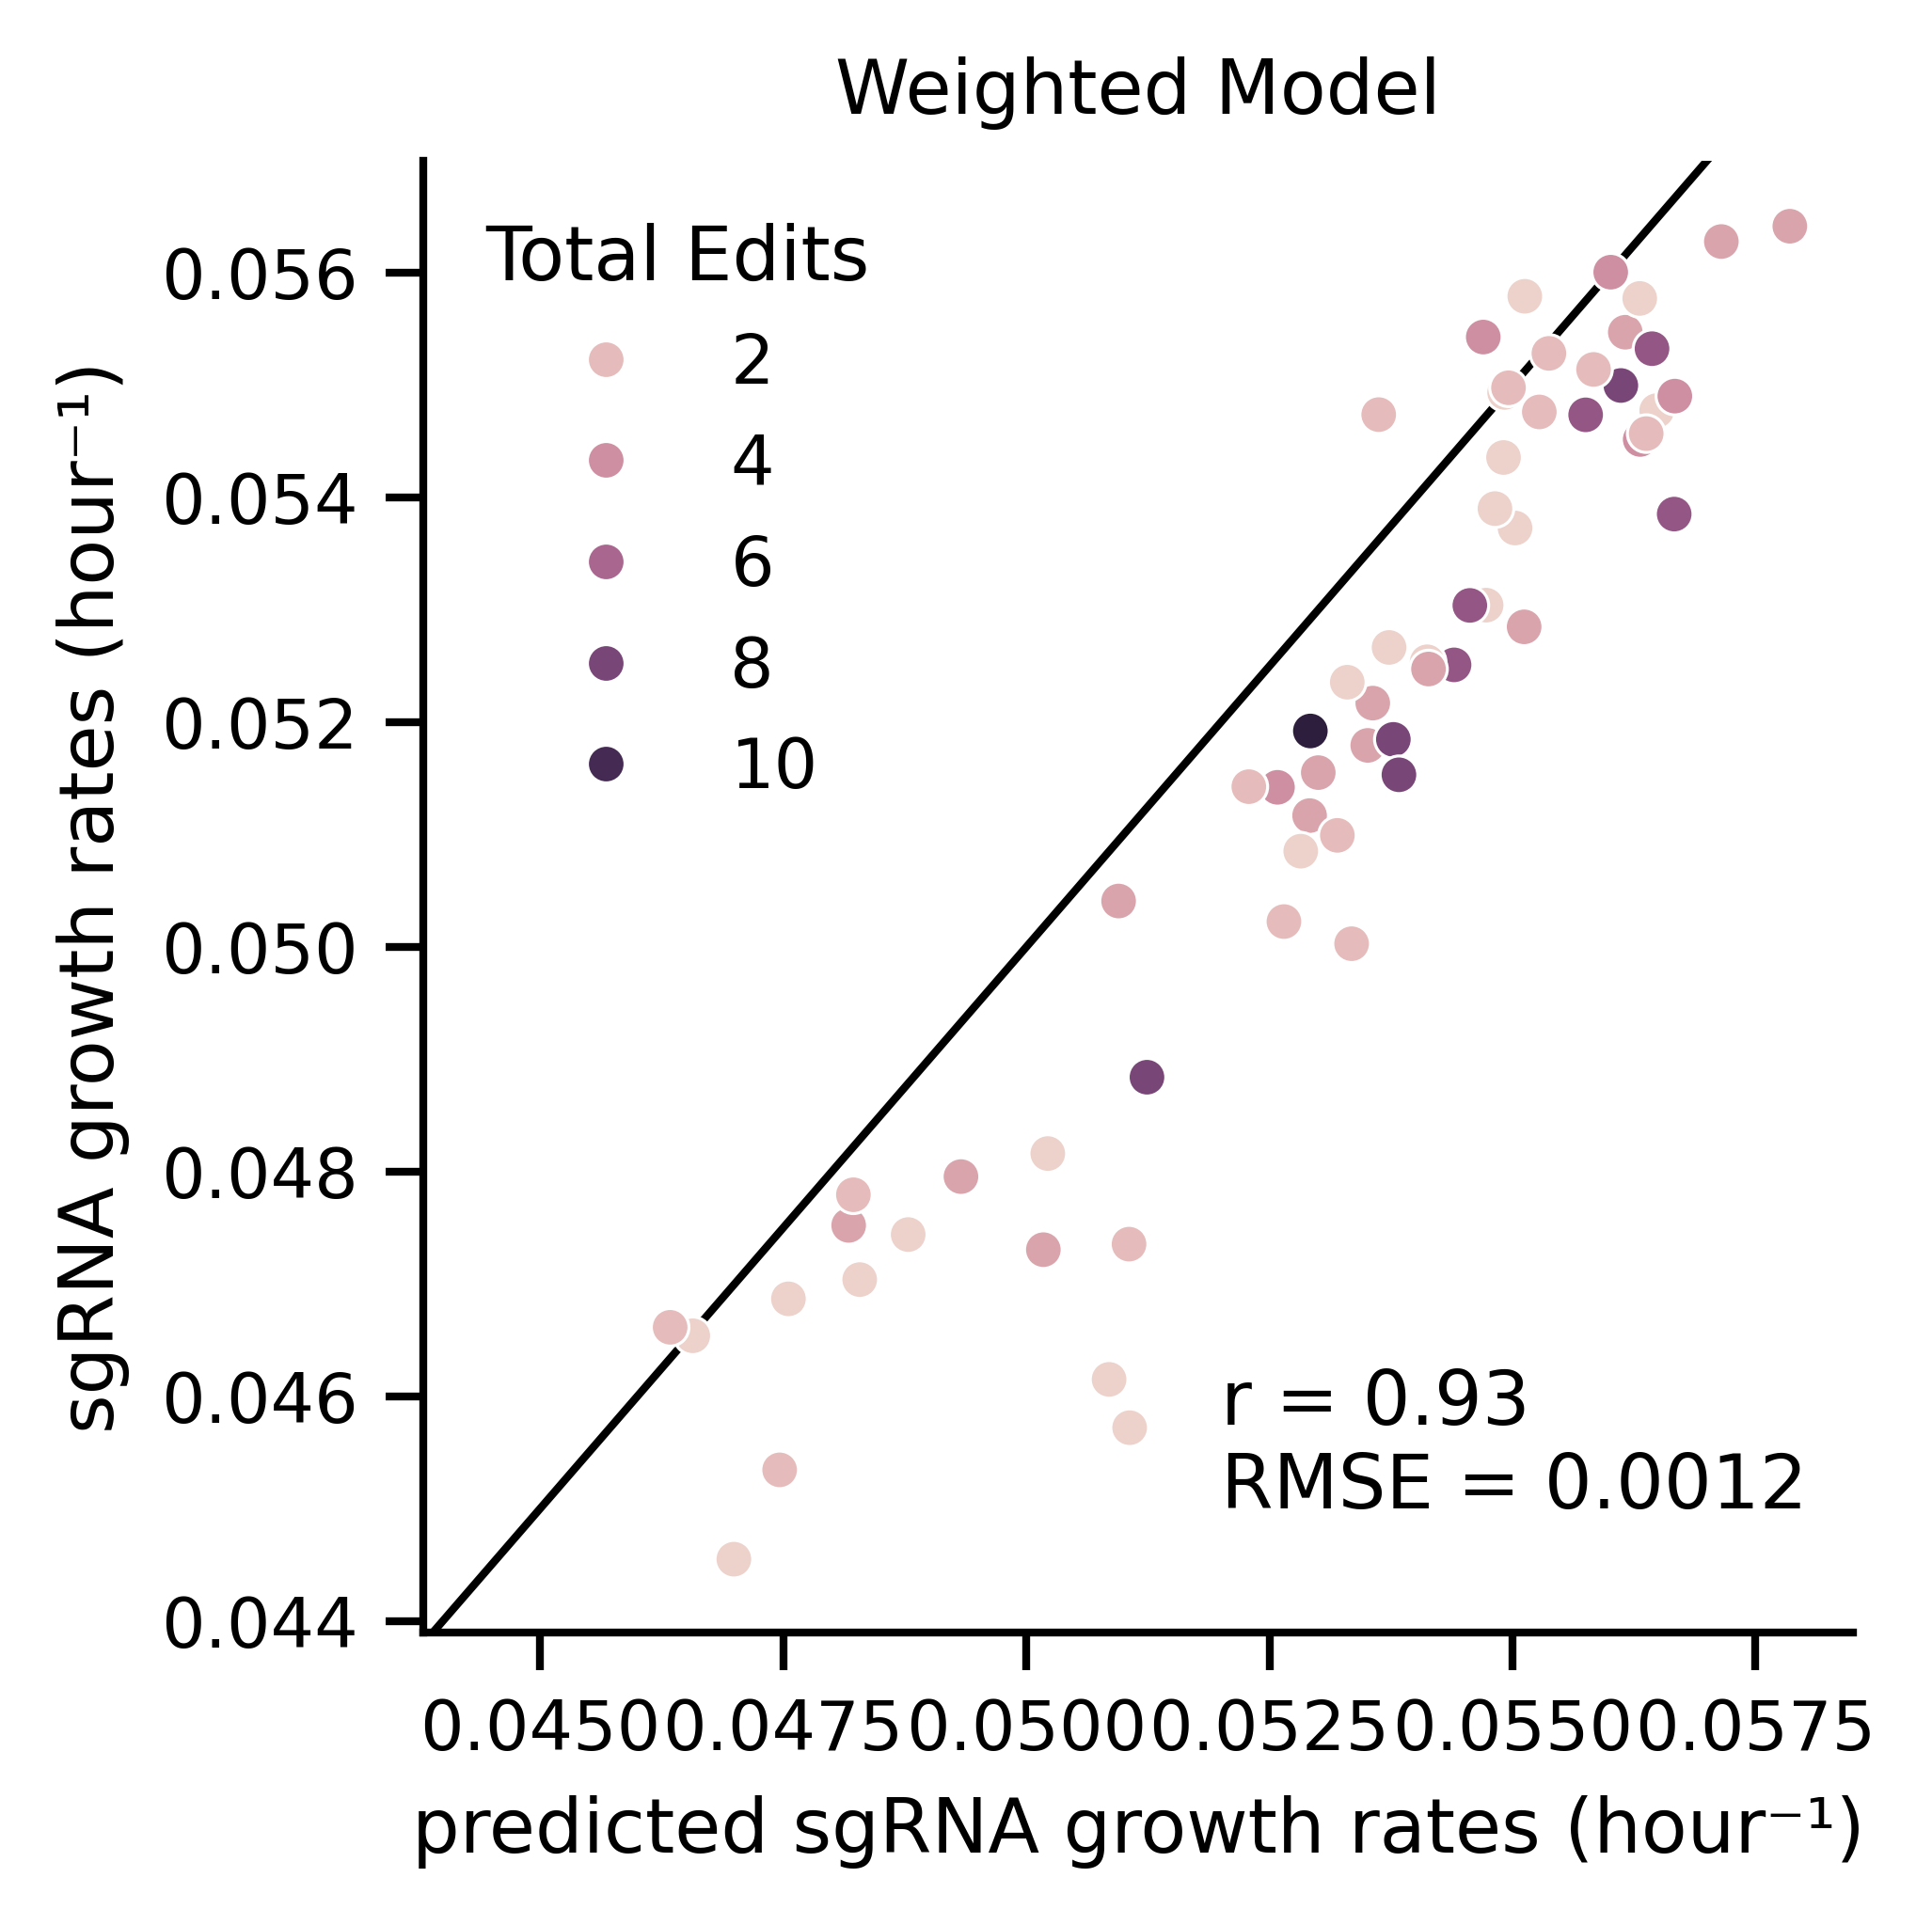

In [73]:
plt.figure(figsize=(3.5,3.5), dpi=600)
Veri_sgRNA = sns.scatterplot(y='sgRNA_r', x='Pred_sgRNA_r', hue='Mismatch', data=Weighted_DF2)
Veri_sgRNA.set(ylabel='sgRNA growth rates (hour⁻¹)', xlabel='predicted sgRNA growth rates (hour⁻¹)', title='Weighted Model', 
              ylim=[0.0439, 0.057], xlim=[0.0438, 0.0585])
sns.lineplot(x=np.linspace(0.01, 0.06), y=np.linspace(0.01, 0.06), color='black', zorder=0, linewidth = 1)
Veri_sgRNA.text(0.052, 0.04575, 'r = 0.93', horizontalalignment='left')
Veri_sgRNA.text(0.052, 0.045, 'RMSE = 0.0012', horizontalalignment='left')
Veri_sgRNA.legend(frameon=False, title='Total Edits')
#sns.move_legend(Veri_sgRNA, "upper left",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
Veri_sgRNA.get_figure().savefig("Weighted Model v sgRNA_250612.pdf" , transparent=True) 

# FIgure 4C

In [74]:
edit_sgRNA_merged_DF['DMS_Prediction'] = edit_sgRNA_merged_DF['DMS_Prediction'].astype(float)

In [75]:
# Note the difference in argument order
Y = edit_sgRNA_merged_DF['mut_r']
X =edit_sgRNA_merged_DF['DMS_Prediction']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(edit_sgRNA_merged_DF['mut_r'], edit_sgRNA_merged_DF['DMS_Prediction']*results.params[1] + results.params[0])

0.004973539368318819

In [76]:
#Test to confirm model is correct
#sns.scatterplot(x = edit_sgRNA_merged_DF['mut_r'], y = edit_sgRNA_merged_DF['mut_r']*results.params[1] + results.params[0])
#sns.regplot(x='DMS_Prediction', y='mut_r',  data=edit_sgRNA_merged_DF)

In [77]:
pearsonr(edit_sgRNA_merged_DF['mut_r'], edit_sgRNA_merged_DF['DMS_Prediction'])

PearsonRResult(statistic=0.749765596658952, pvalue=5.173549276017243e-35)

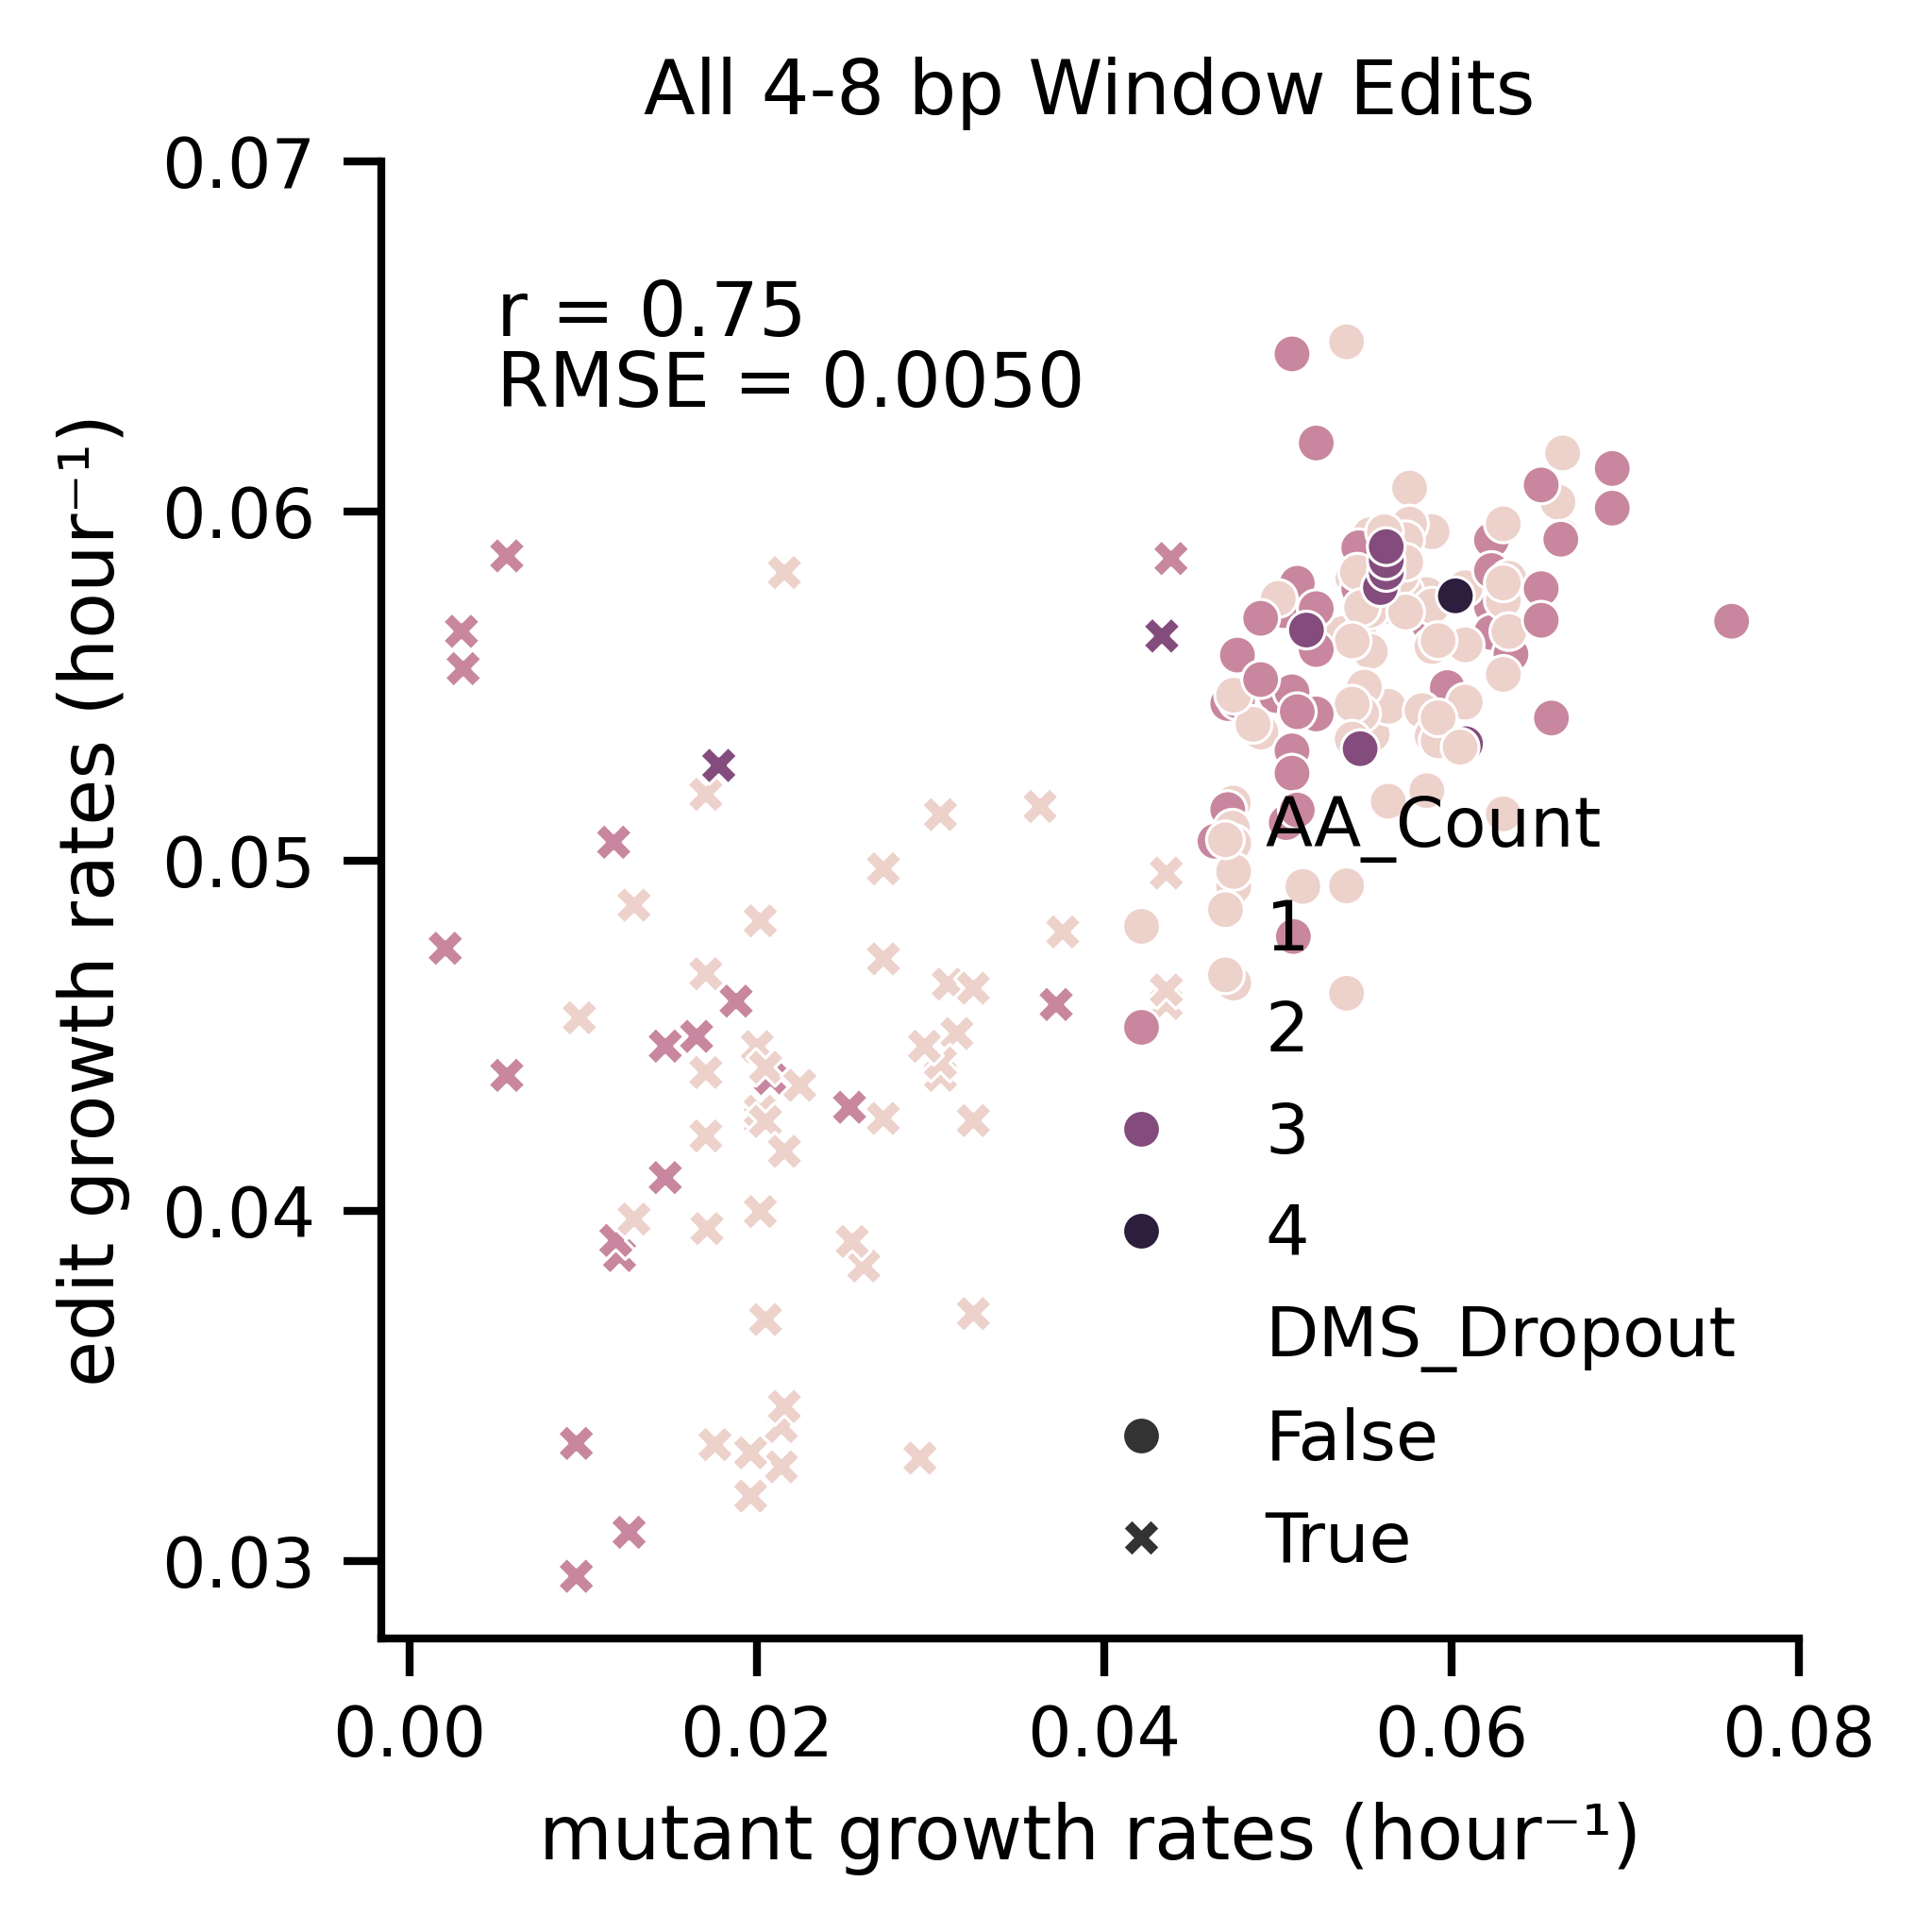

In [78]:
plt.figure(figsize=(3.5,3.5), dpi=600)
Veri_sgRNA = sns.scatterplot(x='DMS_Prediction', y='mut_r', hue='AA_Count', style='DMS_Dropout',  data=edit_sgRNA_merged_DF)
Veri_sgRNA.set(xlabel='mutant growth rates (hour⁻¹)', ylabel='edit growth rates (hour⁻¹)', title='All 4-8 bp Window Edits',
              xticks=[0,0.02,0.04,0.06, 0.08] , yticks=[0.03, 0.04, 0.05, 0.06, 0.07])
Veri_sgRNA.text(0.005, 0.065, 'r = 0.75', horizontalalignment='left')
Veri_sgRNA.text(0.005, 0.063, 'RMSE = 0.0050', horizontalalignment='left')
Veri_sgRNA.legend(frameon=False, loc=4)
#sns.move_legend(Veri_sgRNA, "upper left", frameon=False,bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
Veri_sgRNA.get_figure().savefig("Veri2 ALL Edits v Mut_250607_v2.pdf" , transparent=True) 

In [79]:
single_AA_edit_sgRNA_merged_DF = edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['AA_Count']==1]
pearsonr(single_AA_edit_sgRNA_merged_DF['mut_r'], single_AA_edit_sgRNA_merged_DF['DMS_Prediction'])

PearsonRResult(statistic=0.8154475989193732, pvalue=2.5795375142055623e-29)

In [80]:
# Note the difference in argument order
Y = single_AA_edit_sgRNA_merged_DF['mut_r']
X = single_AA_edit_sgRNA_merged_DF['DMS_Prediction']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(single_AA_edit_sgRNA_merged_DF['mut_r'], single_AA_edit_sgRNA_merged_DF['DMS_Prediction']*results.params[1] + results.params[0])

0.0043689785361011165

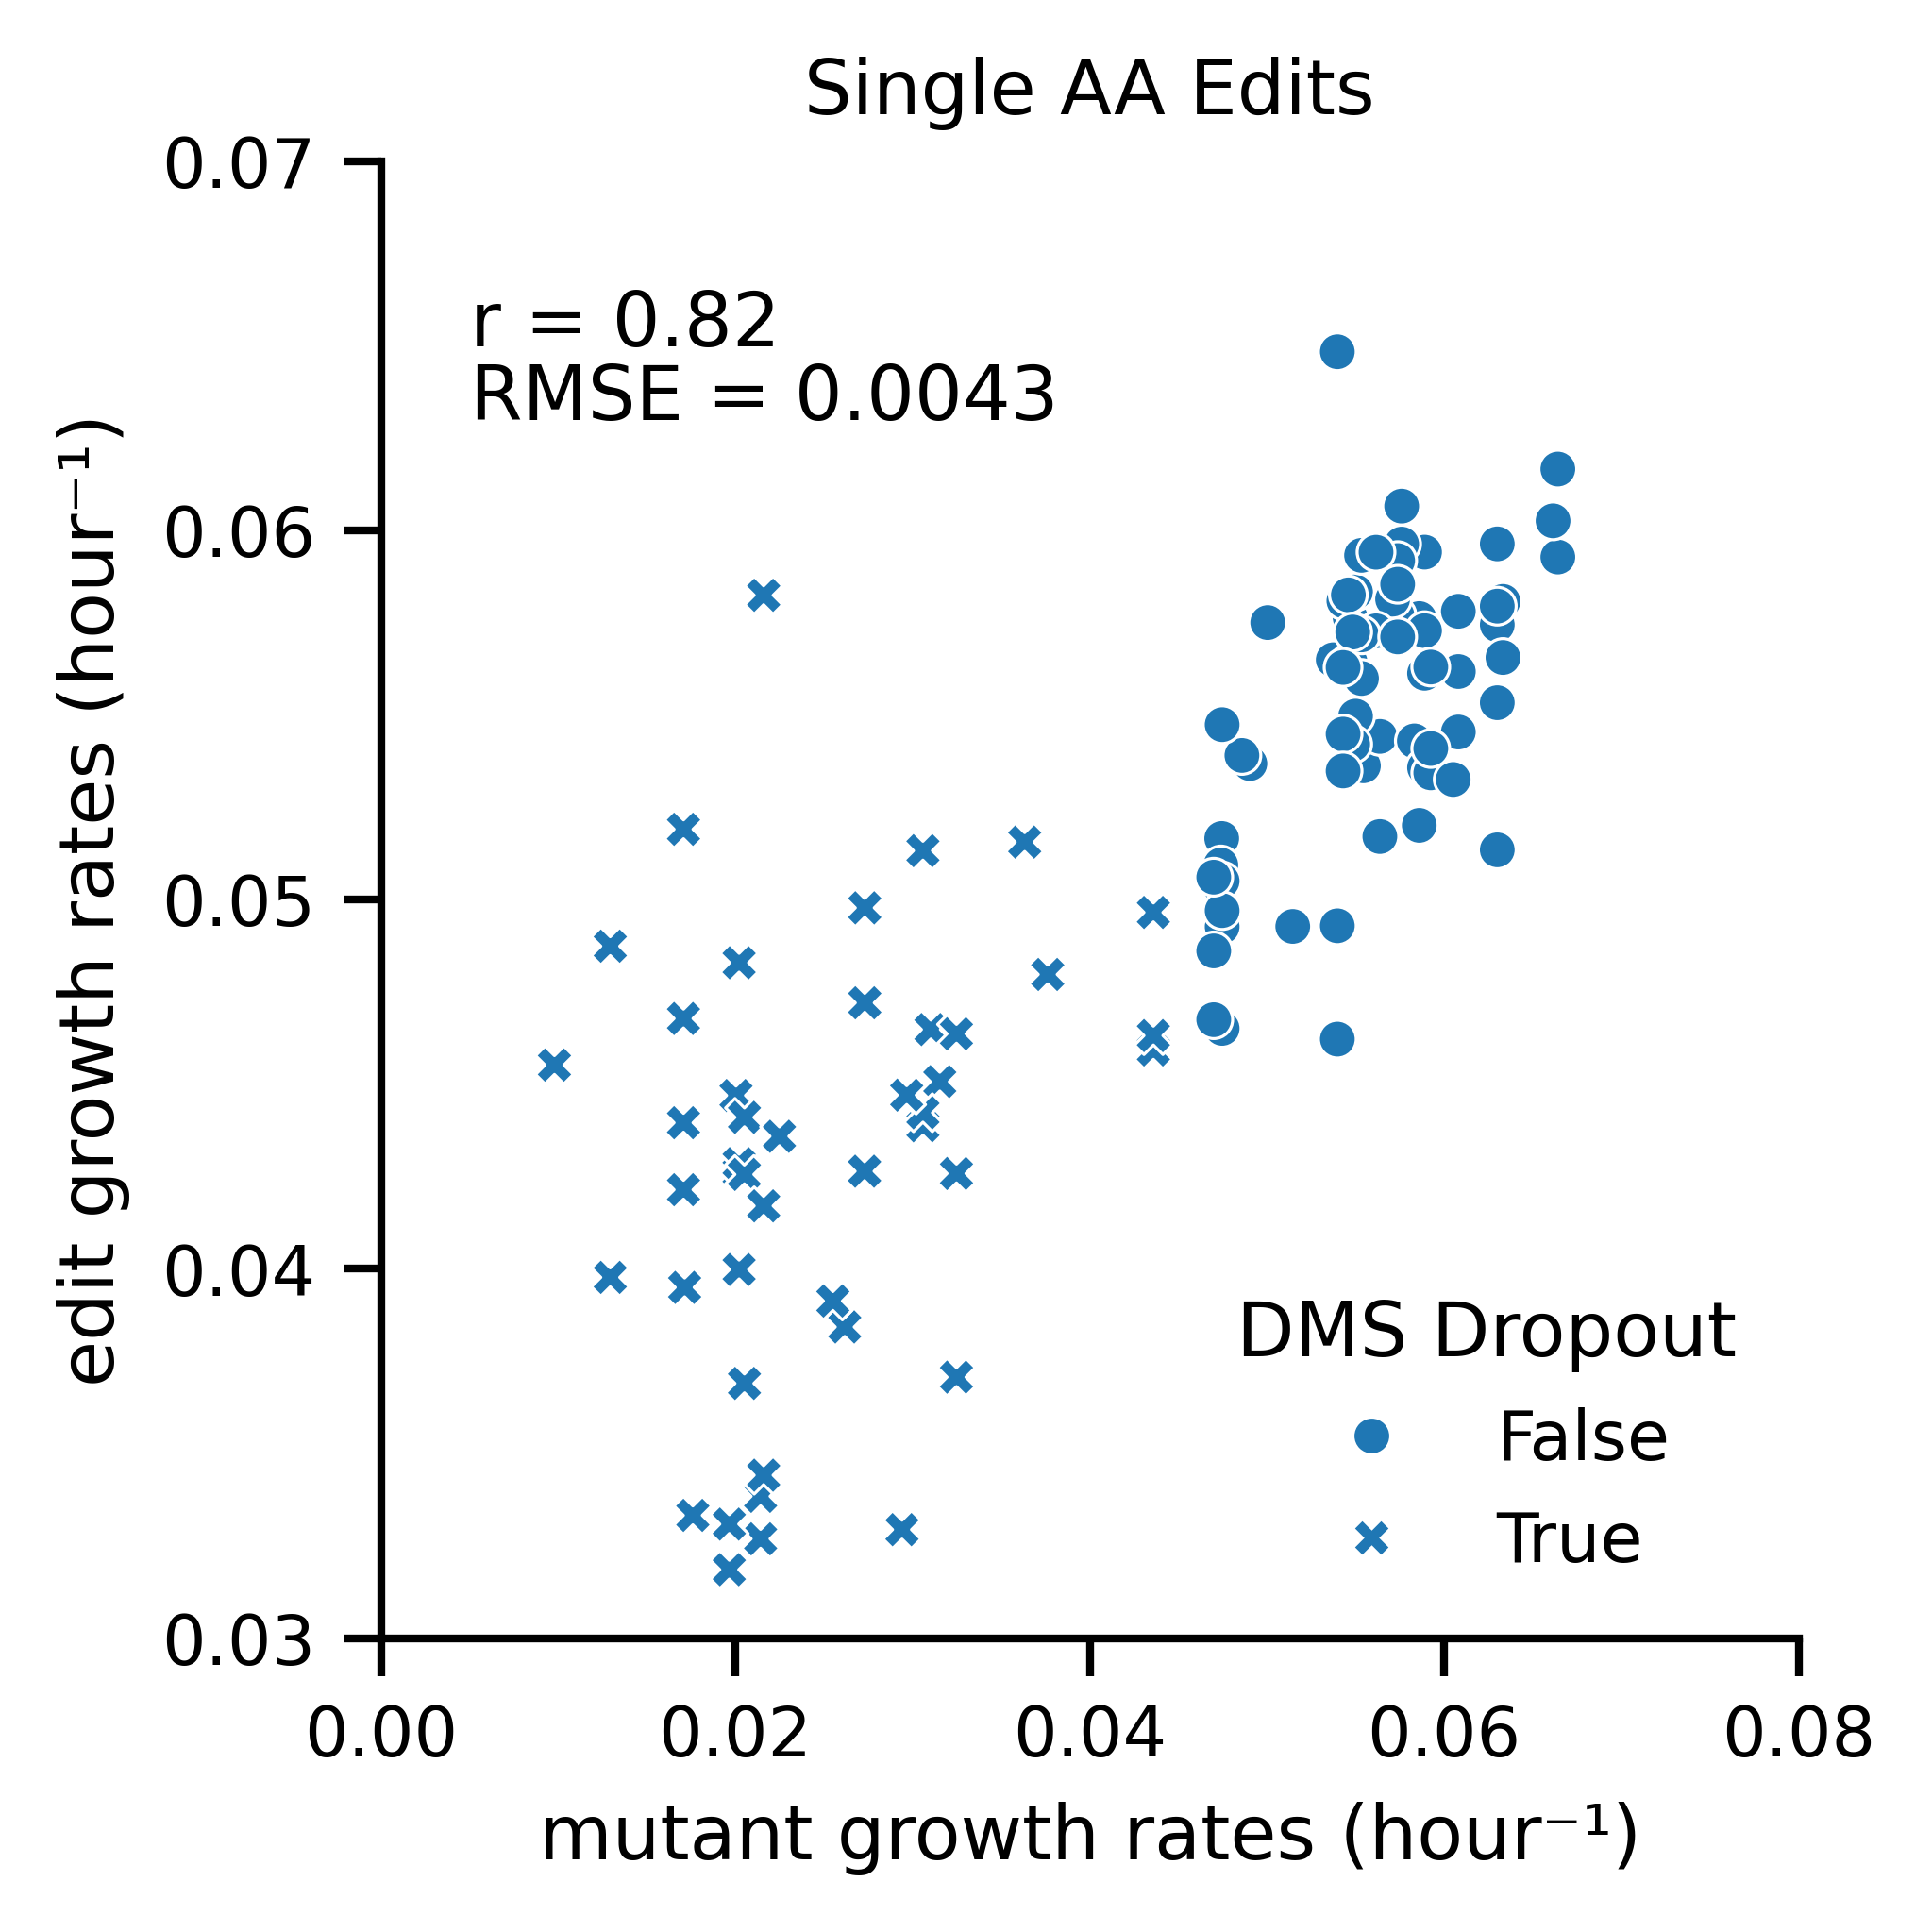

In [81]:
plt.figure(figsize=(3.5,3.5), dpi=600)
Veri_sgRNA = sns.scatterplot(x='DMS_Prediction', y='mut_r', style='DMS_Dropout',  data=single_AA_edit_sgRNA_merged_DF)
Veri_sgRNA.set(xlabel='mutant growth rates (hour⁻¹)', ylabel='edit growth rates (hour⁻¹)', title='Single AA Edits',
               xticks=[0,0.02,0.04,0.06, 0.08] , yticks=[0.03, 0.04, 0.05, 0.06, 0.07])
Veri_sgRNA.text(0.005, 0.065, 'r = 0.82', horizontalalignment='left')
Veri_sgRNA.text(0.005, 0.063, 'RMSE = 0.0043', horizontalalignment='left')
Veri_sgRNA.legend(frameon=False, loc=4, title='DMS Dropout')
#sns.move_legend(Veri_sgRNA, "upper left", frameon=False,bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
Veri_sgRNA.get_figure().savefig("Veri2 Single Edits v Mut_250607.pdf" , transparent=True) 

In [82]:
single_AA_edit_sgRNA_merged_DF.loc[(single_AA_edit_sgRNA_merged_DF['DMS_Prediction']<0.03) & (single_AA_edit_sgRNA_merged_DF['mut_r']>0.055)]

,Mismatch,Freq,FC_mut,Group,WT_FC,Norm_FC_mut,mut_r,Mut_Nuc,Mut_AA,DMS_Prediction,...,control_FC,Norm_FC_sgRNA,sgRNA_r,DMS_Dropout,Window4_8_Edit_Count,Window2_12_Edit_Count,Nucleotides Edited,Window4_8_Edit_Freq_Sum,Relative_Edit_Freq,Relative_Edit_Freq_bin
106,"[""[802, 'C']""]",0.000328,1.46409,6,0.726702,2.014704,0.058243,"[[gtg, gCg, V, 270, A]]",V270A,0.021596,...,1.173081,0.901062,0.054518,True,4,4,1,0.189395,0.001732,"(0.0, 0.05]"


In [83]:
edit_sgRNA_merged_DF['Mut_AA_str'] = edit_sgRNA_merged_DF['Mut_AA'].astype(str)
mean_muts = edit_sgRNA_merged_DF[['Mut_AA_str', 'AA_Count', 'DMS_Dropout',  'DMS_Prediction', 'mut_r']].groupby(['Mut_AA_str', 'AA_Count', 'DMS_Dropout', 'DMS_Prediction']).mean().reset_index()

In [84]:
pearsonr(mean_muts['mut_r'], mean_muts['DMS_Prediction'])

PearsonRResult(statistic=0.7554663668124999, pvalue=5.339218615336566e-21)

In [85]:
# Note the difference in argument order
Y = mean_muts['mut_r']
X = mean_muts['DMS_Prediction']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(mean_muts['mut_r'], mean_muts['DMS_Prediction']*results.params[1] + results.params[0])

0.004846535091734713

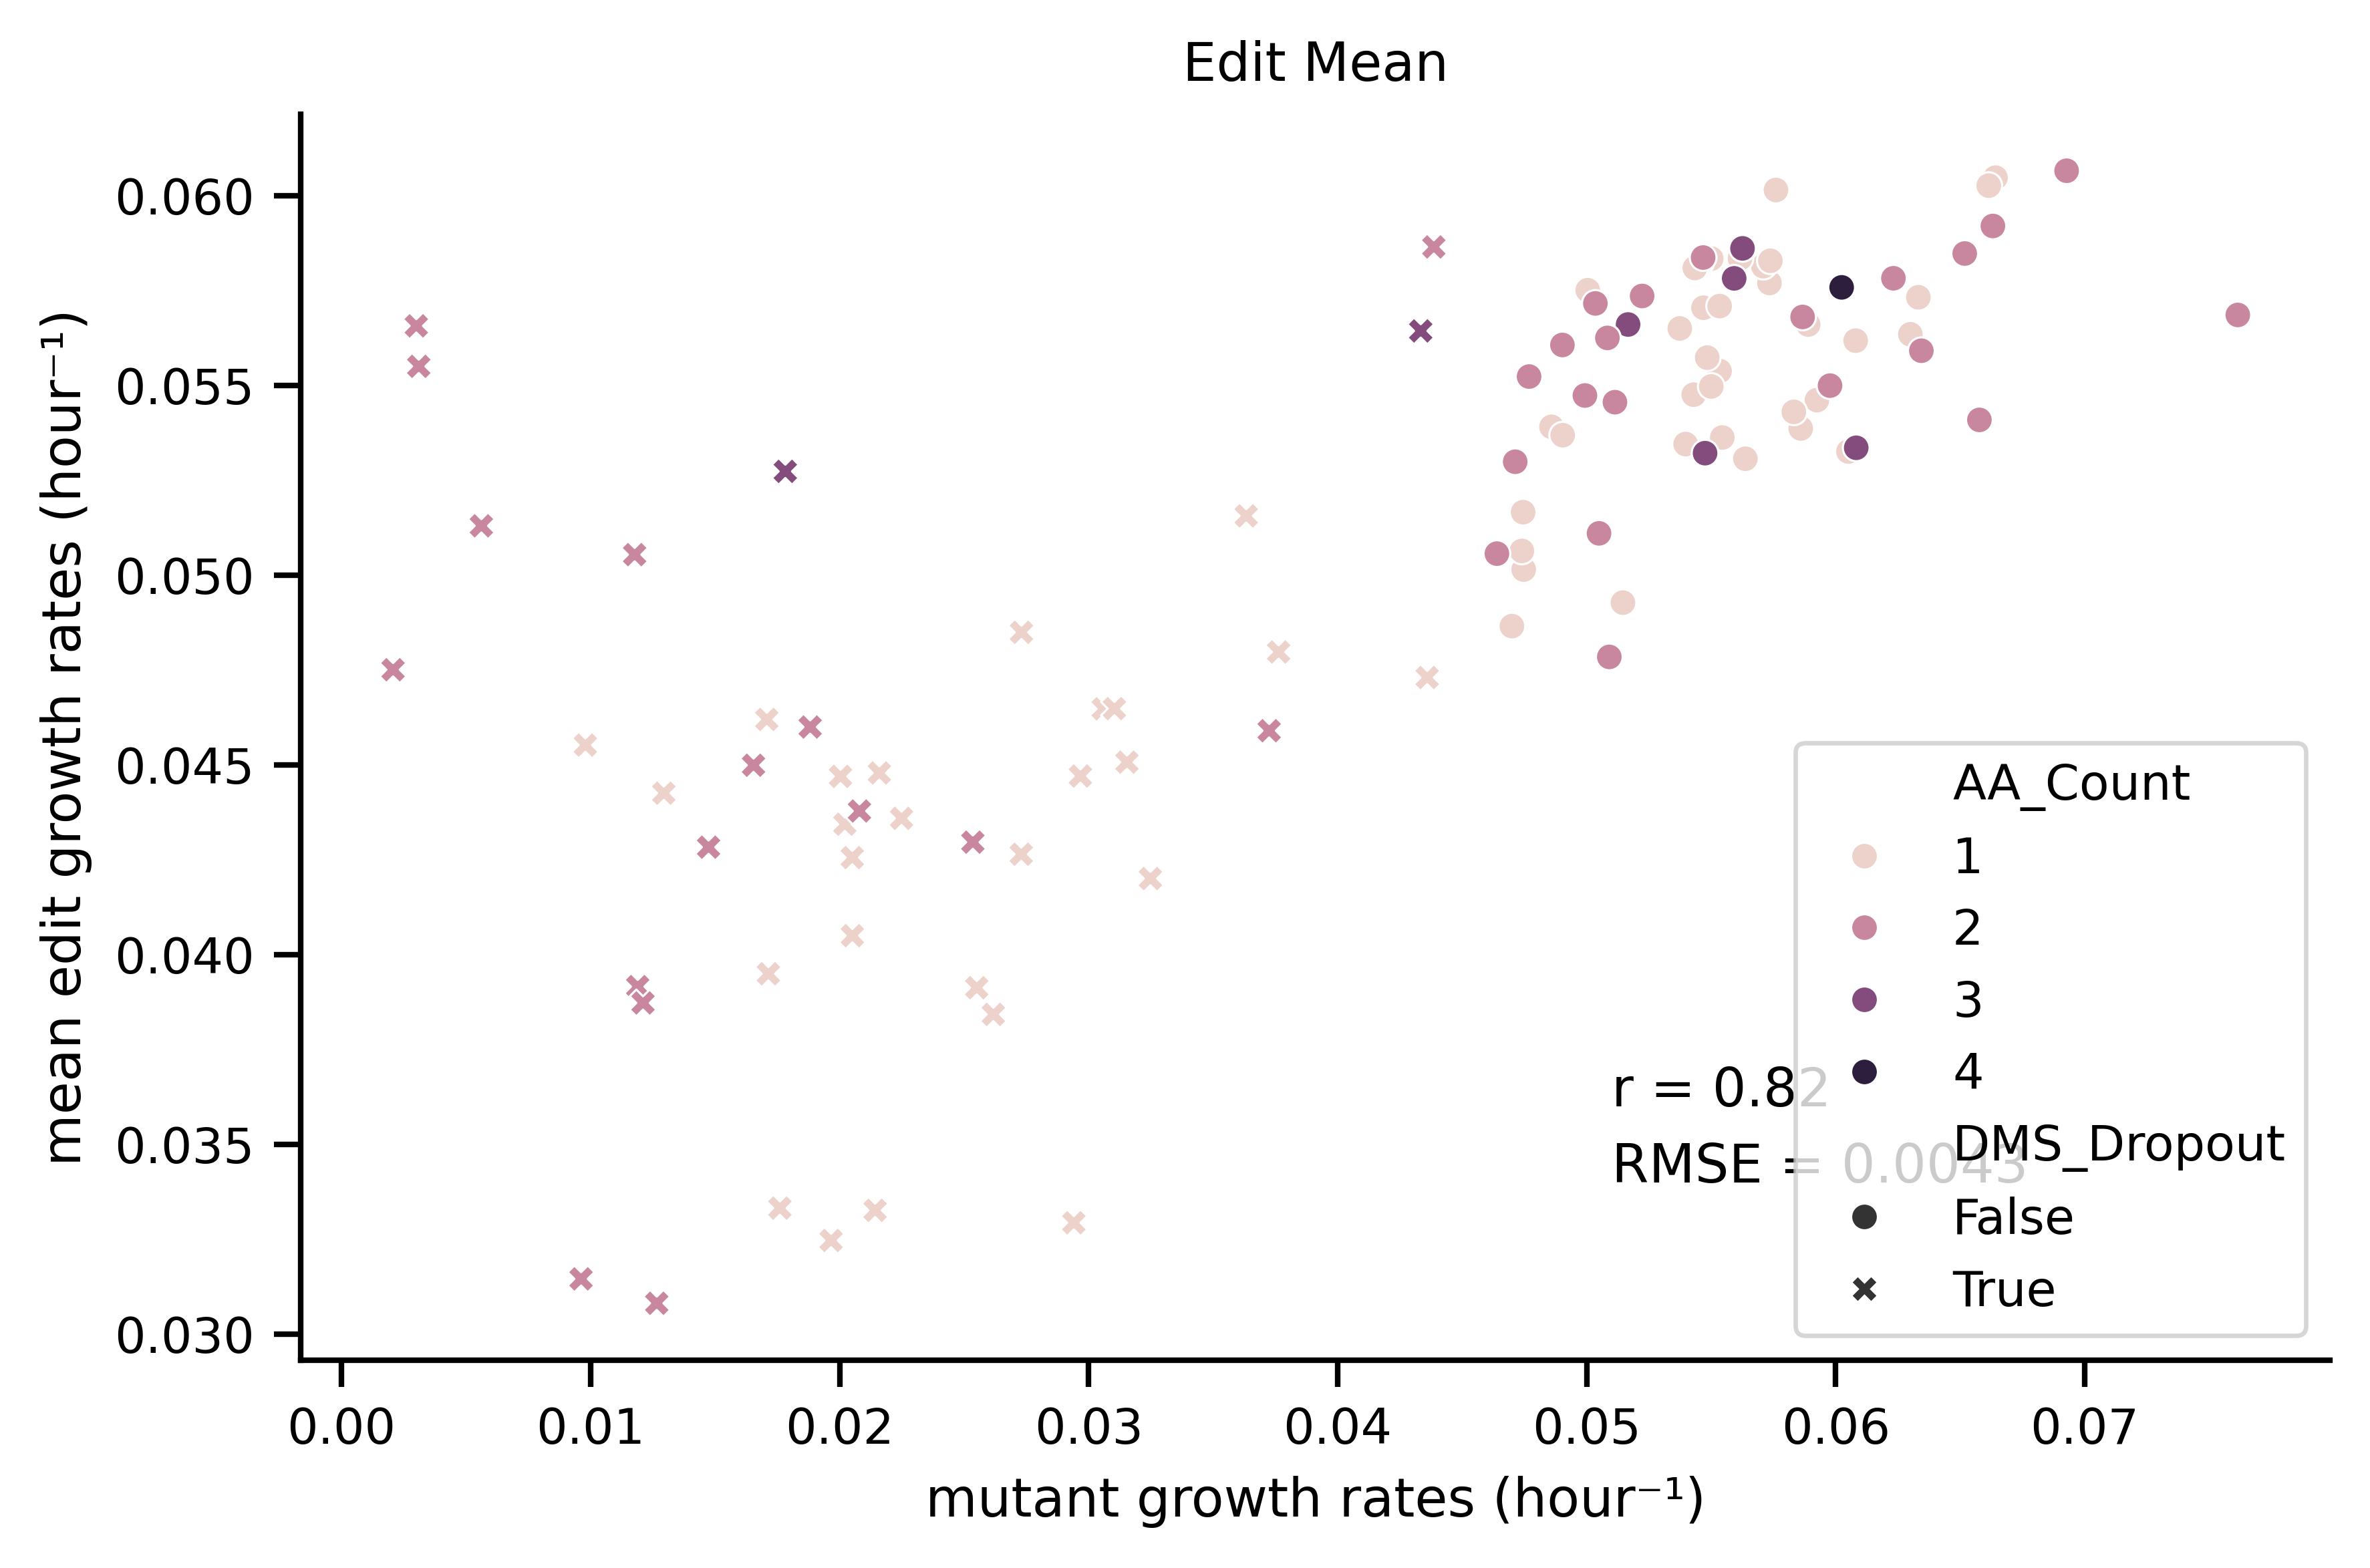

In [86]:
plt.figure(figsize=(6,4), dpi=600)
Veri_sgRNA = sns.scatterplot(x='DMS_Prediction', y='mut_r', hue='AA_Count', style='DMS_Dropout', data=mean_muts)
Veri_sgRNA.set(xlabel='mutant growth rates (hour⁻¹)', ylabel='mean edit growth rates (hour⁻¹)', title='Edit Mean')
Veri_sgRNA.text(0.051, 0.036, 'r = 0.82', horizontalalignment='left')
Veri_sgRNA.text(0.051, 0.034, 'RMSE = 0.0043', horizontalalignment='left')
#sns.move_legend(Veri_sgRNA, "upper left", frameon=False,bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

In [88]:
high_freq = edit_sgRNA_merged_DF.loc[edit_sgRNA_merged_DF['Freq']>0.01]
pearsonr(high_freq['mut_r'], high_freq['DMS_Prediction'])

PearsonRResult(statistic=0.8751522430204481, pvalue=2.9113068934544354e-27)

In [89]:
# Note the difference in argument order
Y = high_freq['mut_r']
X = high_freq['DMS_Prediction']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

rmse(high_freq['mut_r'], high_freq['DMS_Prediction']*results.params[1] + results.params[0])

0.004219372826833134

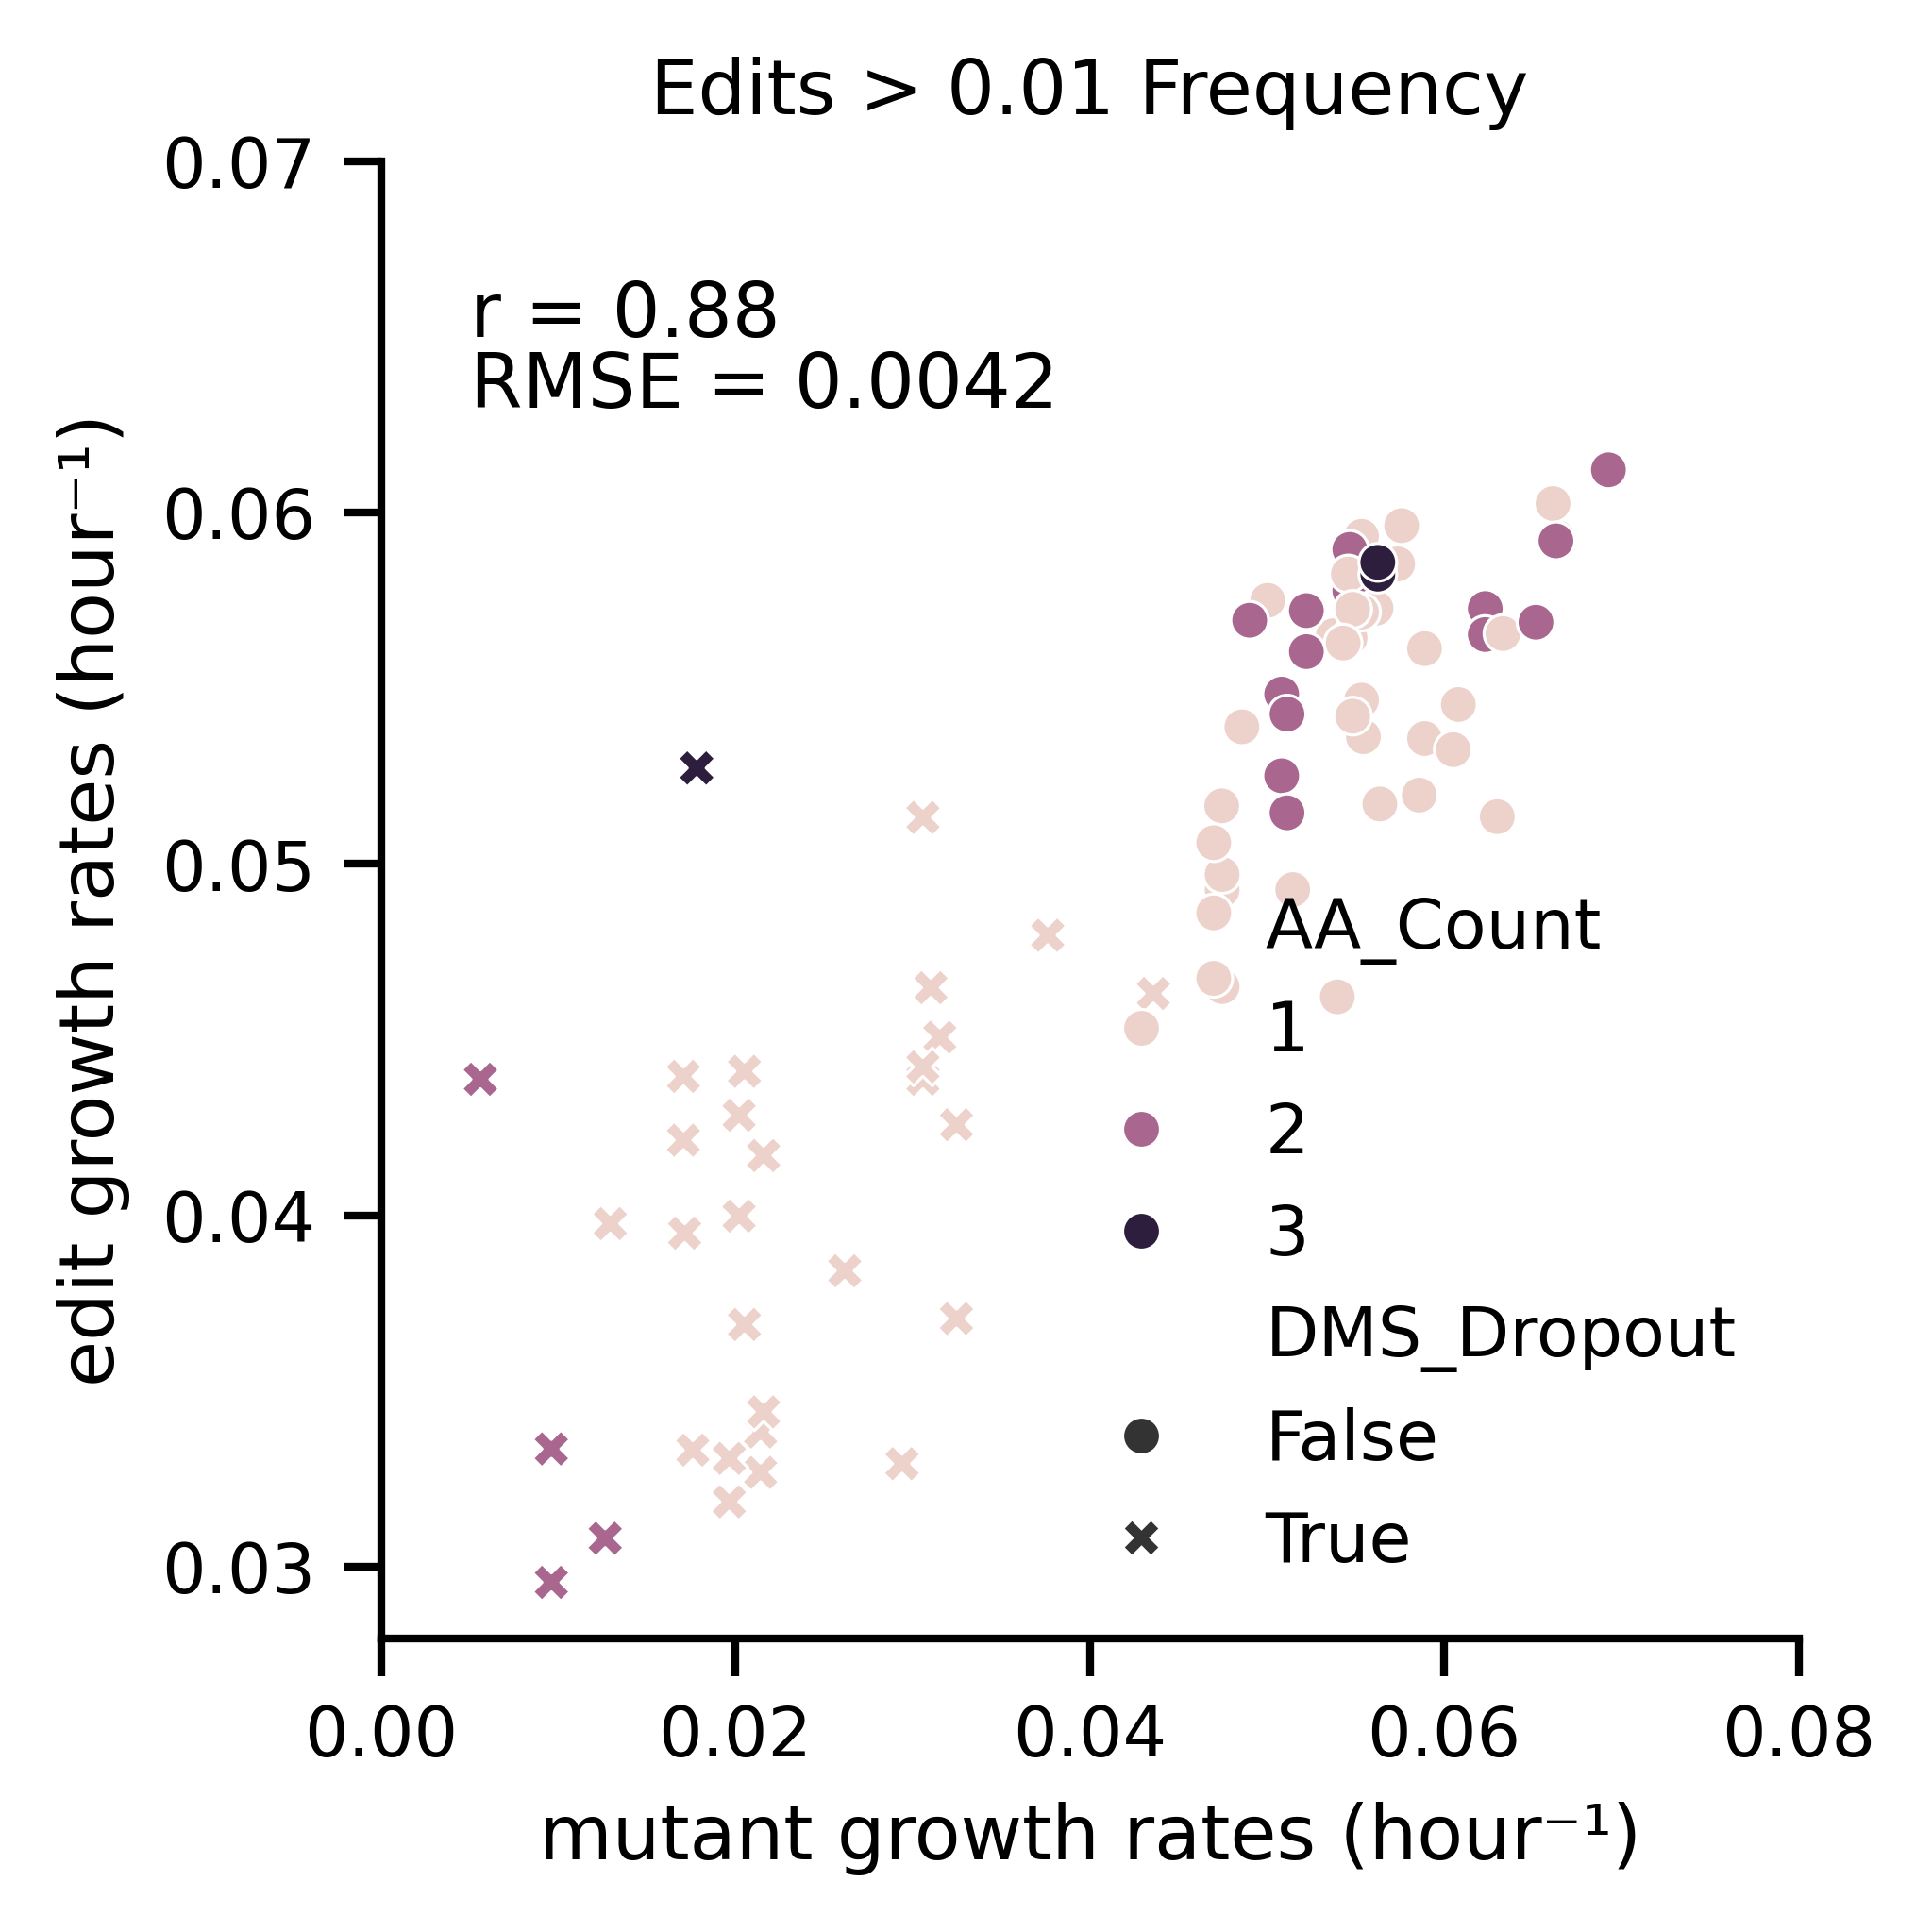

In [90]:
plt.figure(figsize=(3.5,3.5), dpi=600)
Veri_sgRNA = sns.scatterplot(x='DMS_Prediction', y='mut_r', hue='AA_Count', style='DMS_Dropout', data=high_freq)
Veri_sgRNA.set(xlabel='mutant growth rates (hour⁻¹)', ylabel='edit growth rates (hour⁻¹)', title='Edits > 0.01 Frequency',
              xticks=[0,0.02,0.04,0.06, 0.08] , yticks=[0.03, 0.04, 0.05, 0.06, 0.07])
Veri_sgRNA.text(0.005, 0.065, 'r = 0.88', horizontalalignment='left')
Veri_sgRNA.text(0.005, 0.063, 'RMSE = 0.0042', horizontalalignment='left')
Veri_sgRNA.legend(frameon=False, loc=4)
#sns.move_legend(Veri_sgRNA, "upper left", frameon=False,bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
Veri_sgRNA.get_figure().savefig("Veri2 High Freq 0.01 v Mut_250607.pdf" , transparent=True) 

In [91]:
high_freq.loc[(high_freq['DMS_Prediction']<0.03) & (high_freq['mut_r']>0.05)]

,Mismatch,Freq,FC_mut,Group,WT_FC,Norm_FC_mut,mut_r,Mut_Nuc,Mut_AA,DMS_Prediction,...,Norm_FC_sgRNA,sgRNA_r,DMS_Dropout,Window4_8_Edit_Count,Window2_12_Edit_Count,Nucleotides Edited,Window4_8_Edit_Freq_Sum,Relative_Edit_Freq,Relative_Edit_Freq_bin,Mut_AA_str
183,"[""[820, 'G']"", ""[825, 'G']"", ""[822, 'G']""]",0.011959,0.620093,12,1.01222,0.612607,0.052731,"[[gac, gGc, D, 276, G], [atg, Gtg, M, 278, V],...","[D276G, M278V, T277A]",0.01782,...,1.07289,0.055326,True,7,6,3,0.438956,0.027244,"(0.0, 0.05]","['D276G', 'M278V', 'T277A']"


In [92]:
DMS_GR_Dict['D276G'], DMS_GR_Dict['T277A'], DMS_GR_Dict['M278V']

(0.0592441234720219, 0.0605092971907639, 0.0150367872598977)